# Patel SMQ2 Pre-processing
## Xiaonan Wang
## 14July2022

This is a template to analysis SMQ2 experiment using scanpy. There are 6 conditions in total:
- WT
- Aldh2 KO
- Fancd2 KO
- p53 KO
- Aldh2 & Fancd2 Double KO
- Aldb2, Fancd2 & p53 Triple KO

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import os
import smqpp
import re
import anndata

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)
print(smqpp.__version__)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5
0.1.2


# Main analysis
## Read in data and QC

In [2]:
# read in metadata
# This needs to be tidied up first
metadir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/MetaData/'
meta_list = np.array(np.sort(os.listdir(metadir)))
meta_list = meta_list[meta_list!='meta_B2.csv']
print(meta_list)
metaL = []
uniCN = []
for f in meta_list:
    meta_sub = pd.read_csv(metadir+f,  engine='python')
    meta_sub= meta_sub.dropna(axis=1, how='all')
    metaL.append(meta_sub)
    uniCN.append(set(meta_sub.columns))
    del meta_sub
uniCN = set.intersection(*uniCN)

# combine meta for all batches
meta = pd.DataFrame([])
for m in metaL:
    meta = meta.append(m.loc[:, uniCN], True)
meta.index=(meta['Sequencing_identifier'].astype(str)+'.'+[x.replace('-', '_') for x in meta['Sequencing_facility_index']]).values
print(meta.shape)

['meta_B1.csv' 'meta_B3.csv' 'meta_B4.csv' 'meta_B5.csv']
(4296, 18)


In [4]:
meta['Sequencing_identifier'].value_counts().sort_index()

SLX-14256    384
SLX-14257    384
SLX-14719    384
SLX-14789    384
SLX-16885    288
SLX-16886    288
SLX-16888    288
SLX-16889    288
SLX-16890     72
SLX-18583    384
SLX-18674    384
SLX-18783    384
SLX-18784    384
Name: Sequencing_identifier, dtype: int64

In [4]:
meta.head(1)

Pool_size Sequencing_identifier  \
SLX-14719.i701_i502        384             SLX-14719   

                    Sequencing_facility_index  \
SLX-14719.i701_i502                 i701-i502   

                    Position_in_96_well_plate_sorted  Number_of_lanes  \
SLX-14719.i701_i502                               A1                2   

                    Sequencing_index Cell_type_subtype  \
SLX-14719.i701_i502        N701-S502      CD71+Ter119+   

                                                               Details  \
SLX-14719.i701_i502  WT_#1_24927 (Aldh2 KO(+/+); Fancd2 KO (+/+); p...   

                    Unique_sample_descriptor       slx Cell_type_general  \
SLX-14719.i701_i502                WT_#1_LSK  RBG22838              EryA   

                    Library_set Average_pooled_library_length_bp FACs  \
SLX-14719.i701_i502       Set A                              546  Yes   

                                  Owner Species  \
SLX-14719.i701_i502  Nicola/Sarah/Patel   mouse   

                    Position_in_96_well_plate_RNAseq Plate_number  
SLX-14719.i701_i502                               A1     Plate_1a

In [3]:
# Remove SLX-16890 from meta as this is bulk
meta = meta.loc[meta['Sequencing_identifier'] != 'SLX-16890', :]

In [4]:
# Now extract information from Details column
meta['Details'] = meta['Details'].astype('category')
catList = list(meta['Details'].cat.categories)
print(len(catList))
print(catList)

28
['DKO_#1_21509 (Aldh2 KO(d/d); Fancd2 KO (d/d); p53 KO (+/+))', 'DKO_#2_23325 (Aldh2 KO(d/d); Fancd2 KO (d/d); p53 KO (+/+))', 'DKO_#3_32124 Aldh2 KO(d/d); Fancd2 KO (d/d)', 'KJBX 10.1B (p53)', 'KJBX10.2b Aldh2(tm1a):WT | Fancd2:WT | P53:WT (WT)', 'KJBX10.2d Aldh2(tm1a):WT | Fancd2:WT | P53:Hom (p53)', 'KJBX5.3f_Aldh2(tm1a):Hom | Fancd2:Hom | P53:Hom (TKO)', 'KJBX7.3b Aldh2(tm1a):Hom | Fancd2:Hom (DKO)', 'KJBX8.3a Aldh2(tm1a):Hom | Fancd2:Hom | P53:Hom (TKO)', 'KJGV 1.8f (WT)', 'N400_Plate1_WT_LSK', 'Sort1_mouse1.3b_KO_EryA_14804 Aldh2 KO(d/d); Fancd2 KO (+/+); p53 KO (+/+)', 'Sort1_mouse1.3b_KO_LSK_14804 Aldh2 KO(d/d); Fancd2 KO (+/+); p53 KO (+/+)', 'Sort1_mouse1.3d_WT_EryA_14806 Aldh2 KO(+/d); Fancd2 KO (+/+); p53 (+/+)', 'Sort1_mouse1.3d_WT_LSK_14806 Aldh2 KO(+/d); Fancd2 KO (+/+); p53 (+/+)', 'Sort1_mouse1.4a_KO_EryA_18193 Aldh2 KO(d/d); Fancd2 KO (+/+); p53 KO (+/+)', 'Sort1_mouse1.4a_KO_LSK_18193 Aldh2 KO(d/d); Fancd2 KO (+/+); p53 KO (+/+)', 'Sort2_mouse1.4b_KO_EryA_18194 Al

In [5]:
# Rename the categories manually
mouseID = ['21509', '23325', '32124', 'KJBX10.1B', 'KJBX10.2b', 'KJBX10.2d',
           'KJBX5.3f', 'KJBX7.3b', 'KJBX8.3a', 'KJGV1.8f', 'KJGV1.8f', '14804', 
           '14804', '14806', '14806','18193', '18193', '18194',
           '18194', '18196', '18196','18197', '18197', '30410', 
           '24927', '28178', '28175', '21481']
mouseID = dict(zip(catList, mouseID))
Condition = ['DKO', 'DKO', 'DKO', 
             'p53KO', 'WT', 'p53KO',
             'TKO', 'DKO', 'TKO', 
             'WT', 'WT', 'Aldh2KO',
             'Aldh2KO', 'WT', 'WT', 
             'Aldh2KO', 'Aldh2KO', 'Fancd2KO', 
             'Fancd2KO', 'Fancd2KO', 'Fancd2KO', 
             'WT', 'WT', 'WT',
             'WT', 'WT', 'WT',
             'p53KO']
Condition = dict(zip(catList, Condition))
Condition1 = ['DKO', 'DKO', 'DKO', 
             'p53KO', 'WT', 'p53KO',
             'TKO', 'DKO', 'TKO', 
             'WT', 'WT', 'Aldh2KO',
             'Aldh2KO', 'WThet', 'WThet', 
             'Aldh2KO', 'Aldh2KO', 'Fancd2KOhet', 
             'Fancd2KOhet', 'Fancd2KOhet', 'Fancd2KOhet', 
             'WThet', 'WThet', 'WT',
             'WT', 'WT', 'WT',
             'p53KO']
Condition1 = dict(zip(catList, Condition1))
Genotype = ['Aldh2(d/d); Fancd2(d/d); p53(+/+)', 'Aldh2(d/d); Fancd2(d/d); p53(+/+)', 'Aldh2(d/d); Fancd2(d/d); p53(+/+)',
           'Aldh2(+/+); Fancd2(+/+); p53(d/d)', 'Aldh2(+/+); Fancd2(+/+); p53(+/+)', 'Aldh2(+/+); Fancd2(+/+); p53(d/d)',
           'Aldh2(d/d); Fancd2(d/d); p53(d/d)', 'Aldh2(d/d); Fancd2(d/d); p53(+/+)', 'Aldh2(d/d); Fancd2(d/d); p53(d/d)',
           'Aldh2(+/+); Fancd2(+/+); p53(+/+)', 'Aldh2(+/+); Fancd2(+/+); p53(+/+)', 'Aldh2(d/d); Fancd2(+/+); p53(+/+)',
           'Aldh2(d/d); Fancd2(+/+); p53(+/+)', 'Aldh2(+/d); Fancd2(+/+); p53(+/+)', 'Aldh2(+/d); Fancd2(+/+); p53(+/+)',
           'Aldh2(d/d); Fancd2(+/+); p53(+/+)', 'Aldh2(d/d); Fancd2(+/+); p53(+/+)', 'Aldh2(+/d); Fancd2(d/d); p53(+/+)',
           'Aldh2(+/d); Fancd2(d/d); p53(+/+)', 'Aldh2(+/d); Fancd2(d/d); p53(+/+)', 'Aldh2(+/d); Fancd2(d/d); p53(+/+)',
           'Aldh2(+/d); Fancd2(+/+); p53(+/+)', 'Aldh2(+/d); Fancd2(+/+); p53(+/+)', 'Aldh2(+/+); Fancd2(+/+); p53(+/+)',
           'Aldh2(+/+); Fancd2(+/+); p53(+/+)', 'Aldh2(+/+); Fancd2(+/+); p53(+/+)', 'Aldh2(+/+); Fancd2(+/+); p53(+/+)',
           'Aldh2(+/+); Fancd2(+/+); p53(d/d)']
Genotype = dict(zip(catList, Genotype))

In [6]:
# save back in meta
meta['MouseID'] = [mouseID[x] for x in meta['Details']]
meta['Condition'] = [Condition[x] for x in meta['Details']]
meta['Condition1'] = [Condition1[x] for x in meta['Details']]
meta['Genotype'] = [Genotype[x] for x in meta['Details']]

In [2]:
# Now read in gene table and count files
Indir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/STAR_results/'
ftable_loc = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/Analysis/features.tsv'
ftable = pd.read_csv(ftable_loc, delimiter='\t', index_col=0, header=None)

In [6]:
ftable.head(2)

1                2
0                                          
ENSMUSG00000051951    Xkr4  Gene Expression
ENSMUSG00000089699  Gm1992  Gene Expression

In [8]:
folder_list = np.array(os.listdir(Indir))
# remove bulk samples
folder_list = np.sort(folder_list[(folder_list!='SLX14873') & (folder_list!='SLX16890')])
print(folder_list)

['SLX14256' 'SLX14257' 'SLX14719' 'SLX14789' 'SLX16885' 'SLX16886'
 'SLX16888' 'SLX16889' 'SLX18583' 'SLX18674' 'SLX18783' 'SLX18784']


In [9]:
# Read in count files
adata = []
for i in range(len(folder_list)):
    print(folder_list[i])
    adata_sub = smqpp.read_in_files(Indir+folder_list[i], ftable)
    adata.append(adata_sub)
    del adata_sub

SLX14256
Count table shape: (384, 31053)
Feature table shape:(31053, 7)
SLX14257
Count table shape: (384, 31053)
Feature table shape:(31053, 7)
SLX14719
Count table shape: (384, 31053)
Feature table shape:(31053, 7)
SLX14789
Count table shape: (384, 31053)
Feature table shape:(31053, 7)
SLX16885
Count table shape: (288, 31053)
Feature table shape:(31053, 7)
SLX16886
Count table shape: (288, 31053)
Feature table shape:(31053, 7)
SLX16888
Count table shape: (288, 31053)
Feature table shape:(31053, 7)
SLX16889
Count table shape: (288, 31053)
Feature table shape:(31053, 7)
SLX18583
Count table shape: (384, 31053)
Feature table shape:(31053, 7)
SLX18674
Count table shape: (384, 31053)
Feature table shape:(31053, 7)
SLX18783
Count table shape: (384, 31053)
Feature table shape:(31053, 7)
SLX18784
Count table shape: (384, 31053)
Feature table shape:(31053, 7)


In [10]:
# Here we need to combine data first
# as there are samples sequenced twice with different SLXs
adata = anndata.AnnData.concatenate(*adata)
adata.obs_names = [x[:-2] for x in adata.obs_names]
adata.obs_names = [x.rstrip('-') for x in adata.obs_names]

In [11]:
print(adata.shape)

(4224, 31053)


In [12]:
# Remove SLX-14256.i706_i503 as md5sum check is wrong
adata = adata[adata.obs_names != 'SLX-14256.i706_i503',:].copy()

In [13]:
print(adata.shape)

(4223, 31053)


In [15]:
meta = meta.loc[adata.obs_names, :].copy()
print(meta.shape)

(4223, 22)


In [18]:
meta['Sequencing_identifier'].value_counts().sort_index()

SLX-14256    383
SLX-14257    384
SLX-14719    384
SLX-14789    384
SLX-16885    288
SLX-16886    288
SLX-16888    288
SLX-16889    288
SLX-18583    384
SLX-18674    384
SLX-18783    384
SLX-18784    384
Name: Sequencing_identifier, dtype: int64

In [19]:
# combine counts
Xall = pd.DataFrame(adata.X)
print(Xall.shape)
Xall['RBGname'] = meta['slx'].values
Xnew = Xall.groupby('RBGname').sum()
print(Xnew.shape)

# combine QCs
QCnames = [x for x in adata.obs_keys() if 'QC' in x]
QCall = adata.obs[QCnames]
print(QCall.shape)
QCall['RBGname'] = meta['slx'].values
QCnew = QCall.groupby('RBGname').sum()
print(QCnew.shape)

# combine ERCCs
ERCCall = pd.DataFrame(adata.obsm['ERCC'])
print(ERCCall.shape)
ERCCall['RBGname'] = meta['slx'].values
ERCCnew = ERCCall.groupby('RBGname').sum()
print(ERCCnew.shape)

(4223, 31053)
(4031, 31053)
(4223, 3)
(4031, 3)
(4223, 92)
(4031, 92)


In [20]:
# Now we combine the new anndata object
adata_new = anndata.AnnData(X=np.array(Xnew), obs=QCnew, var=adata.var)
adata_new.obsm['ERCC'] = np.array(ERCCnew)

In [21]:
meta_new = meta.drop_duplicates(subset=['slx'])
print(meta_new.shape)
meta_new.index = meta_new['slx']

(4031, 22)


In [22]:
adata_new.obs = pd.concat([adata_new.obs, meta_new], axis=1, join='inner')

In [23]:
adata_new.obs.head(3)

QC_Unassigned_Ambiguity  QC_Unassigned_NoFeatures  \
RBG22838                    58504                    229692   
RBG22839                    52224                    301268   
RBG22840                    36432                    208761   

          QC_Unassigned_Unmapped  Pool_size Sequencing_identifier  \
RBG22838                 1184629        384             SLX-14719   
RBG22839                 1194132        384             SLX-14719   
RBG22840                 1112346        384             SLX-14719   

         Sequencing_facility_index Position_in_96_well_plate_sorted  \
RBG22838                 i701-i502                               A1   
RBG22839                 i702-i502                               A2   
RBG22840                 i703-i502                               A3   

          Number_of_lanes Sequencing_index Cell_type_subtype  ...  \
RBG22838                2        N701-S502      CD71+Ter119+  ...   
RBG22839                2        N702-S502      CD71+Ter119+  ...   
RBG22840                2        N703-S502      CD71+Ter119+  ...   

         Average_pooled_library_length_bp FACs               Owner Species  \
RBG22838                              546  Yes  Nicola/Sarah/Patel   mouse   
RBG22839                              546  Yes  Nicola/Sarah/Patel   mouse   
RBG22840                              546  Yes  Nicola/Sarah/Patel   mouse   

         Position_in_96_well_plate_RNAseq Plate_number MouseID Condition  \
RBG22838                               A1     Plate_1a   24927        WT   
RBG22839                               A2     Plate_1a   24927        WT   
RBG22840                               A3     Plate_1a   24927        WT   

         Condition1                           Genotype  
RBG22838         WT  Aldh2(+/+); Fancd2(+/+); p53(+/+)  
RBG22839         WT  Aldh2(+/+); Fancd2(+/+); p53(+/+)  
RBG22840         WT  Aldh2(+/+); Fancd2(+/+); p53(+/+)  

[3 rows x 25 columns]

In [23]:
adata_new.obs['Condition'].value_counts()

WT          1509
DKO          776
p53KO        578
TKO          400
Fancd2KO     384
Aldh2KO      384
Name: Condition, dtype: int64

In [24]:
adata_new.shape

(4031, 31053)

In [25]:
# define QC thresholds
cutoff_14256 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(150000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }
cutoff_14257 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(120000),
           'fGenes:nTotal': 0.1,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.25
          }
cutoff_14719 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(150000),
           'fGenes:nTotal': 0.1,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.28
          }
cutoff_14789 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(150000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }
cutoff_16885 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(120000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }
cutoff_16886 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(120000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }
cutoff_16888 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(120000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }
cutoff_16889 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(120000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }

cutoff_18583 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(100000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }

cutoff_18674 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(100000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }

cutoff_18783 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(100000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }

cutoff_18784 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(120000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }

In [26]:
cutoff = [cutoff_14256, cutoff_14257, cutoff_14719, cutoff_14789, cutoff_16885, cutoff_16886, cutoff_16888, cutoff_16889,
         cutoff_18583, cutoff_18674, cutoff_18783, cutoff_18784]

Index(['SLX-14256', 'SLX-14257', 'SLX-14719', 'SLX-14789', 'SLX-16885',
       'SLX-16886', 'SLX-16888', 'SLX-16889', 'SLX-18583', 'SLX-18674',
       'SLX-18783', 'SLX-18784'],
      dtype='object')
mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Number of passed cells: 369
Number of failed cells: 14


Trying to set attribute `.obs` of view, copying.


mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Number of passed cells: 354
Number of failed cells: 30


Trying to set attribute `.obs` of view, copying.


mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Number of passed cells: 346
Number of failed cells: 38


Trying to set attribute `.obs` of view, copying.


mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Number of passed cells: 367
Number of failed cells: 17


Trying to set attribute `.obs` of view, copying.


mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Number of passed cells: 256
Number of failed cells: 32


Trying to set attribute `.obs` of view, copying.


mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Number of passed cells: 283
Number of failed cells: 5


Trying to set attribute `.obs` of view, copying.


mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']


Trying to set attribute `.obs` of view, copying.


Number of passed cells: 275
Number of failed cells: 13
mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Number of passed cells: 285
Number of failed cells: 3


Trying to set attribute `.obs` of view, copying.


mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Number of passed cells: 348
Number of failed cells: 36


Trying to set attribute `.obs` of view, copying.


mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']


Trying to set attribute `.obs` of view, copying.


Number of passed cells: 360
Number of failed cells: 24
mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Number of passed cells: 266
Number of failed cells: 22


Trying to set attribute `.obs` of view, copying.


mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']


Trying to set attribute `.obs` of view, copying.


Number of passed cells: 276
Number of failed cells: 12


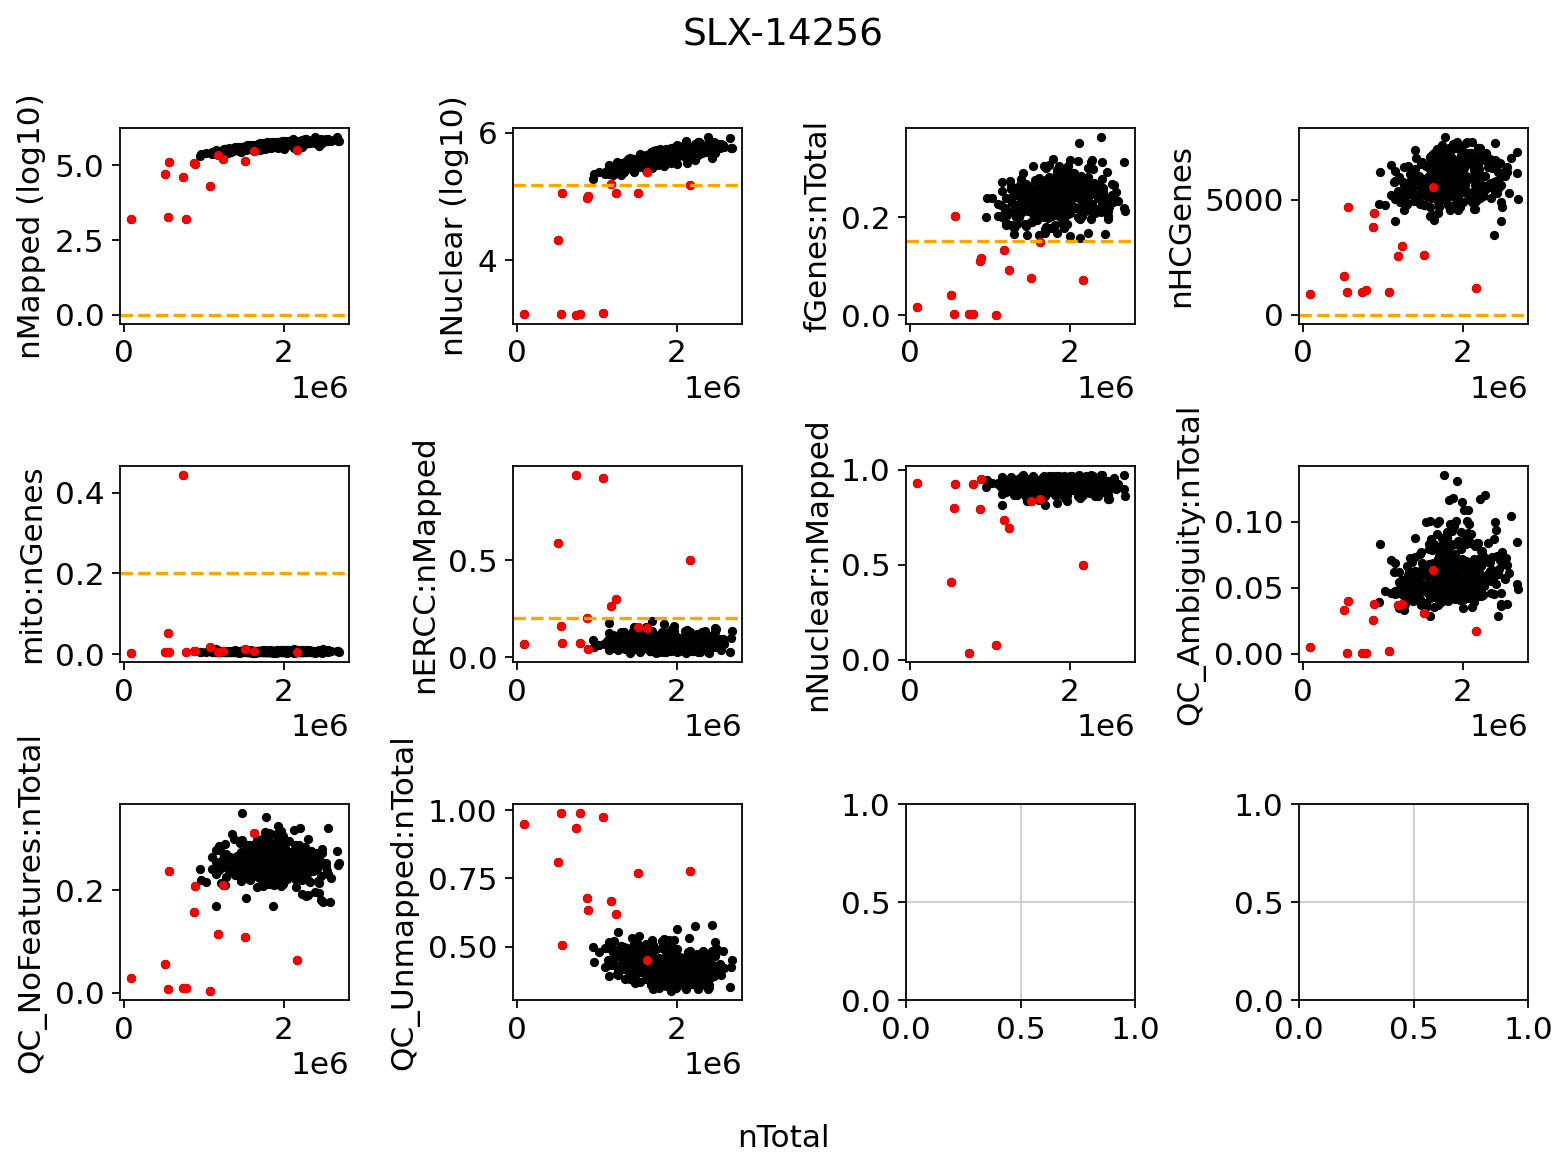

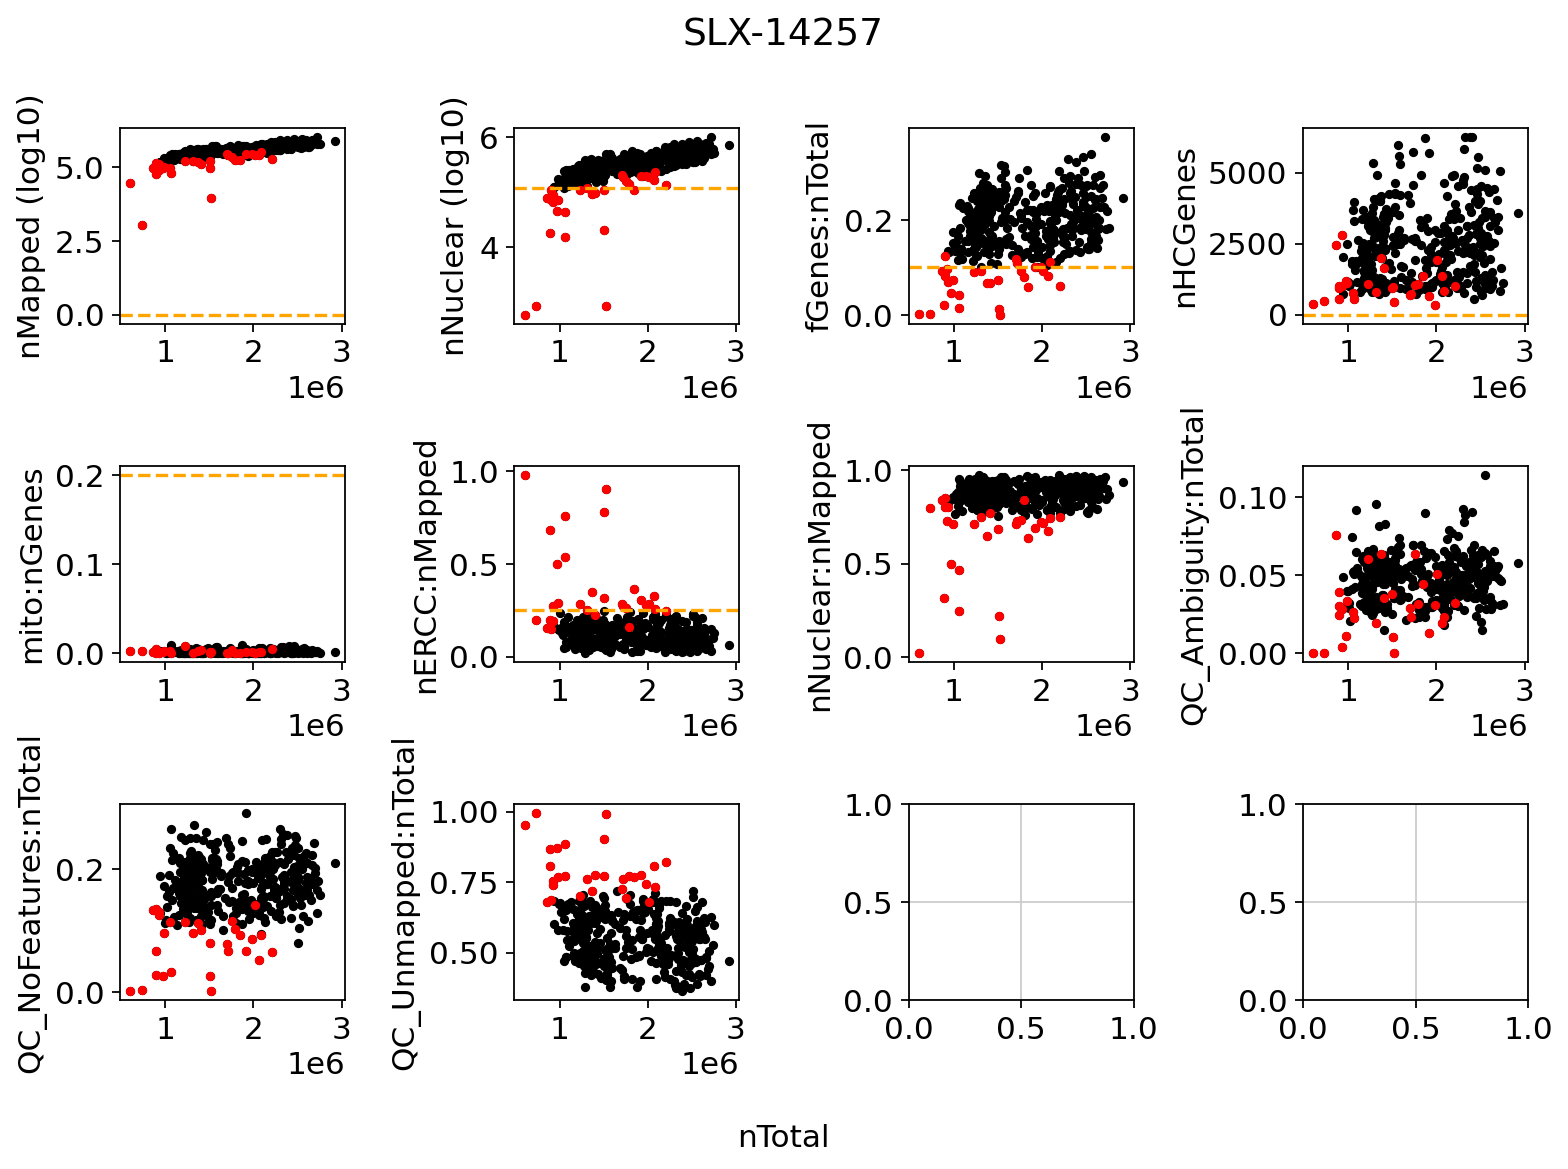

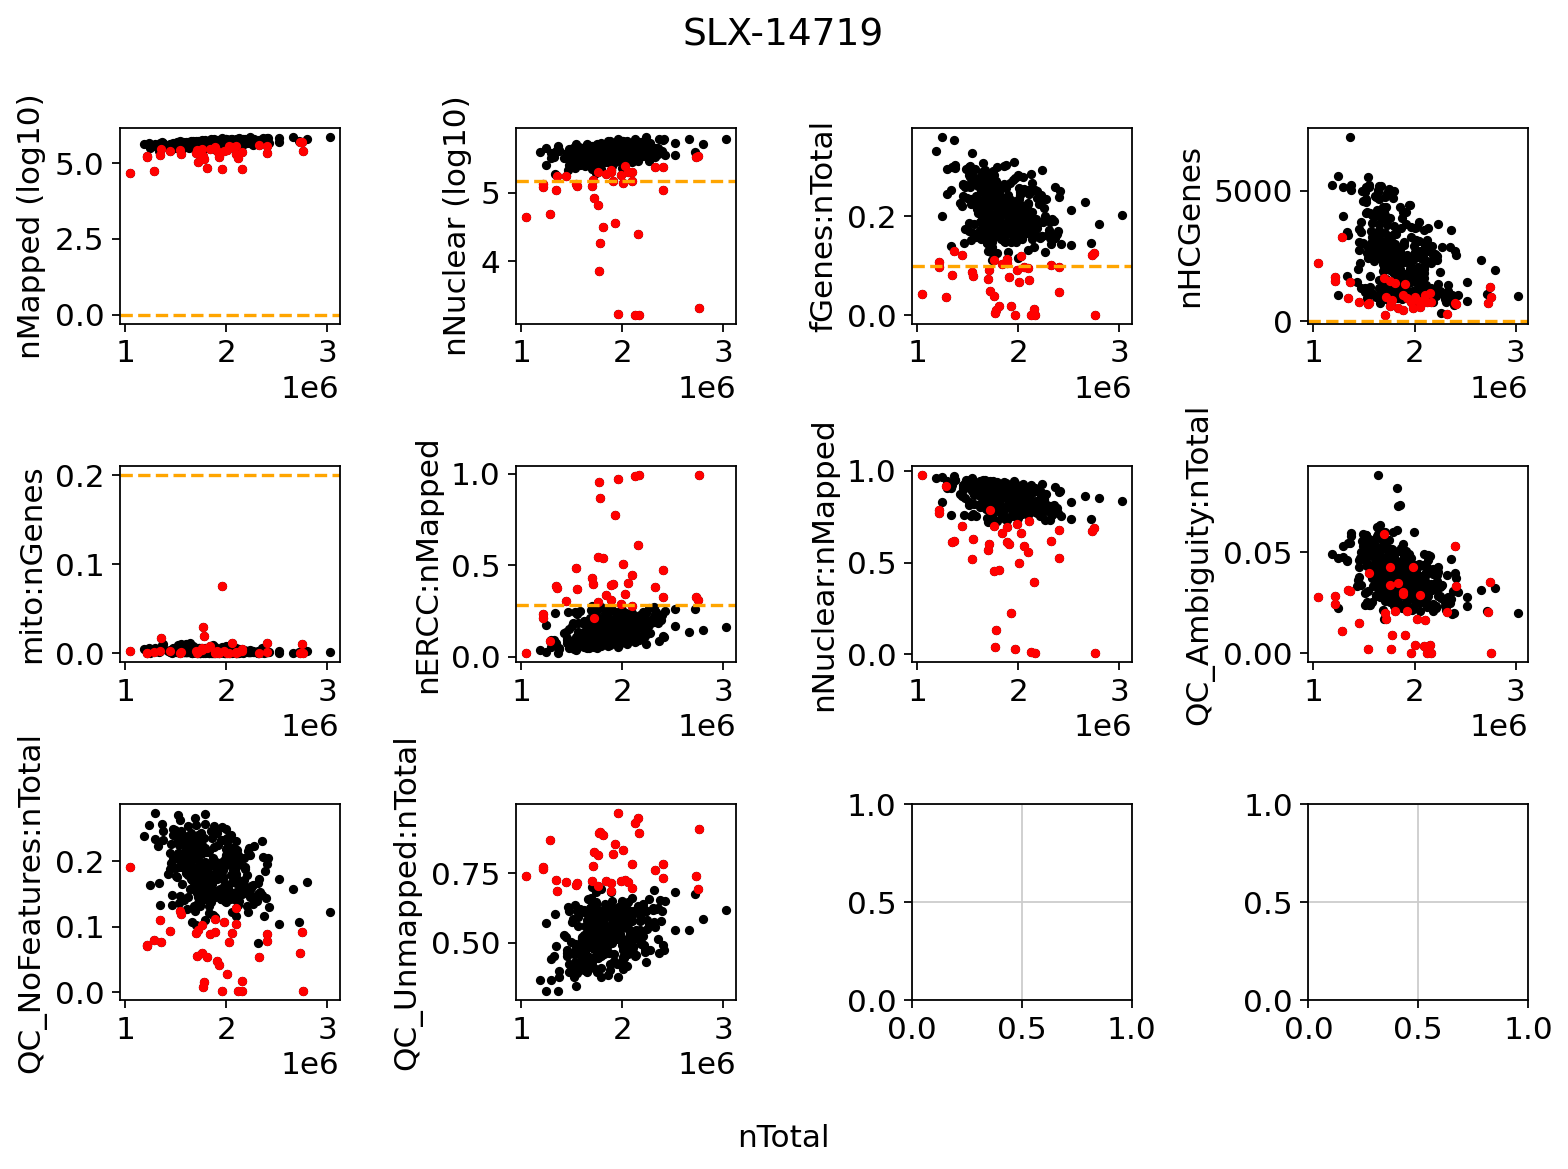

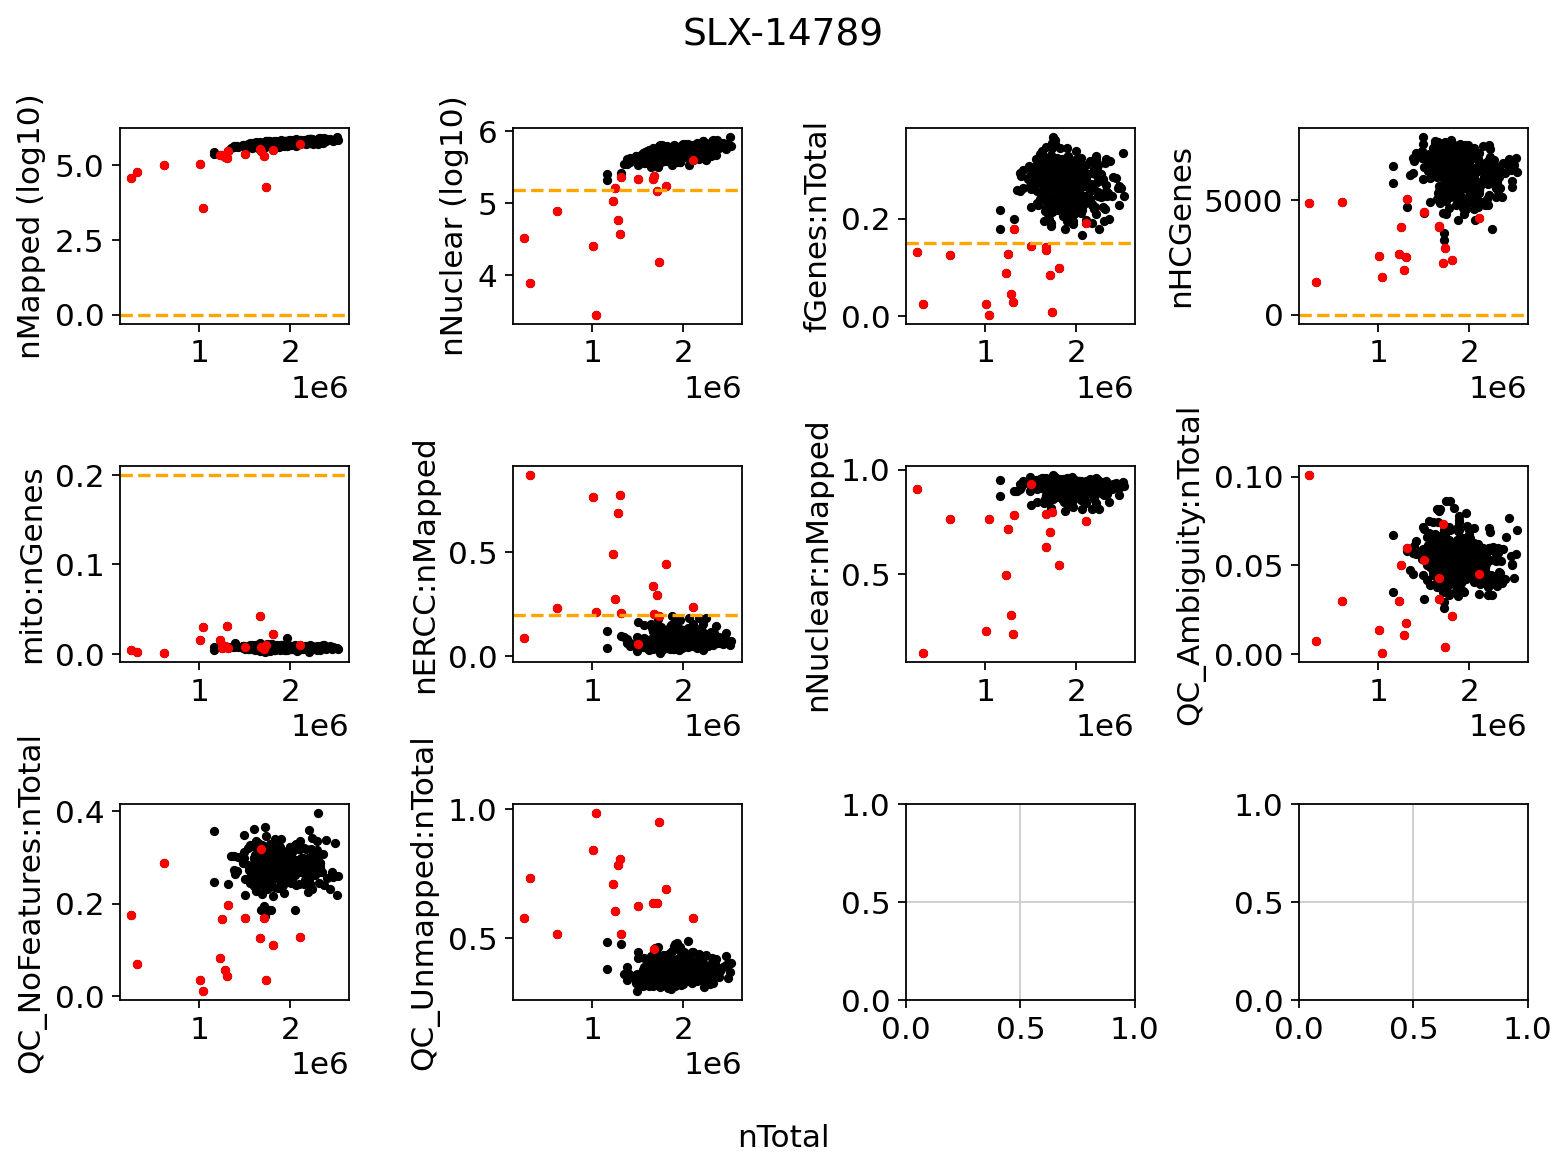

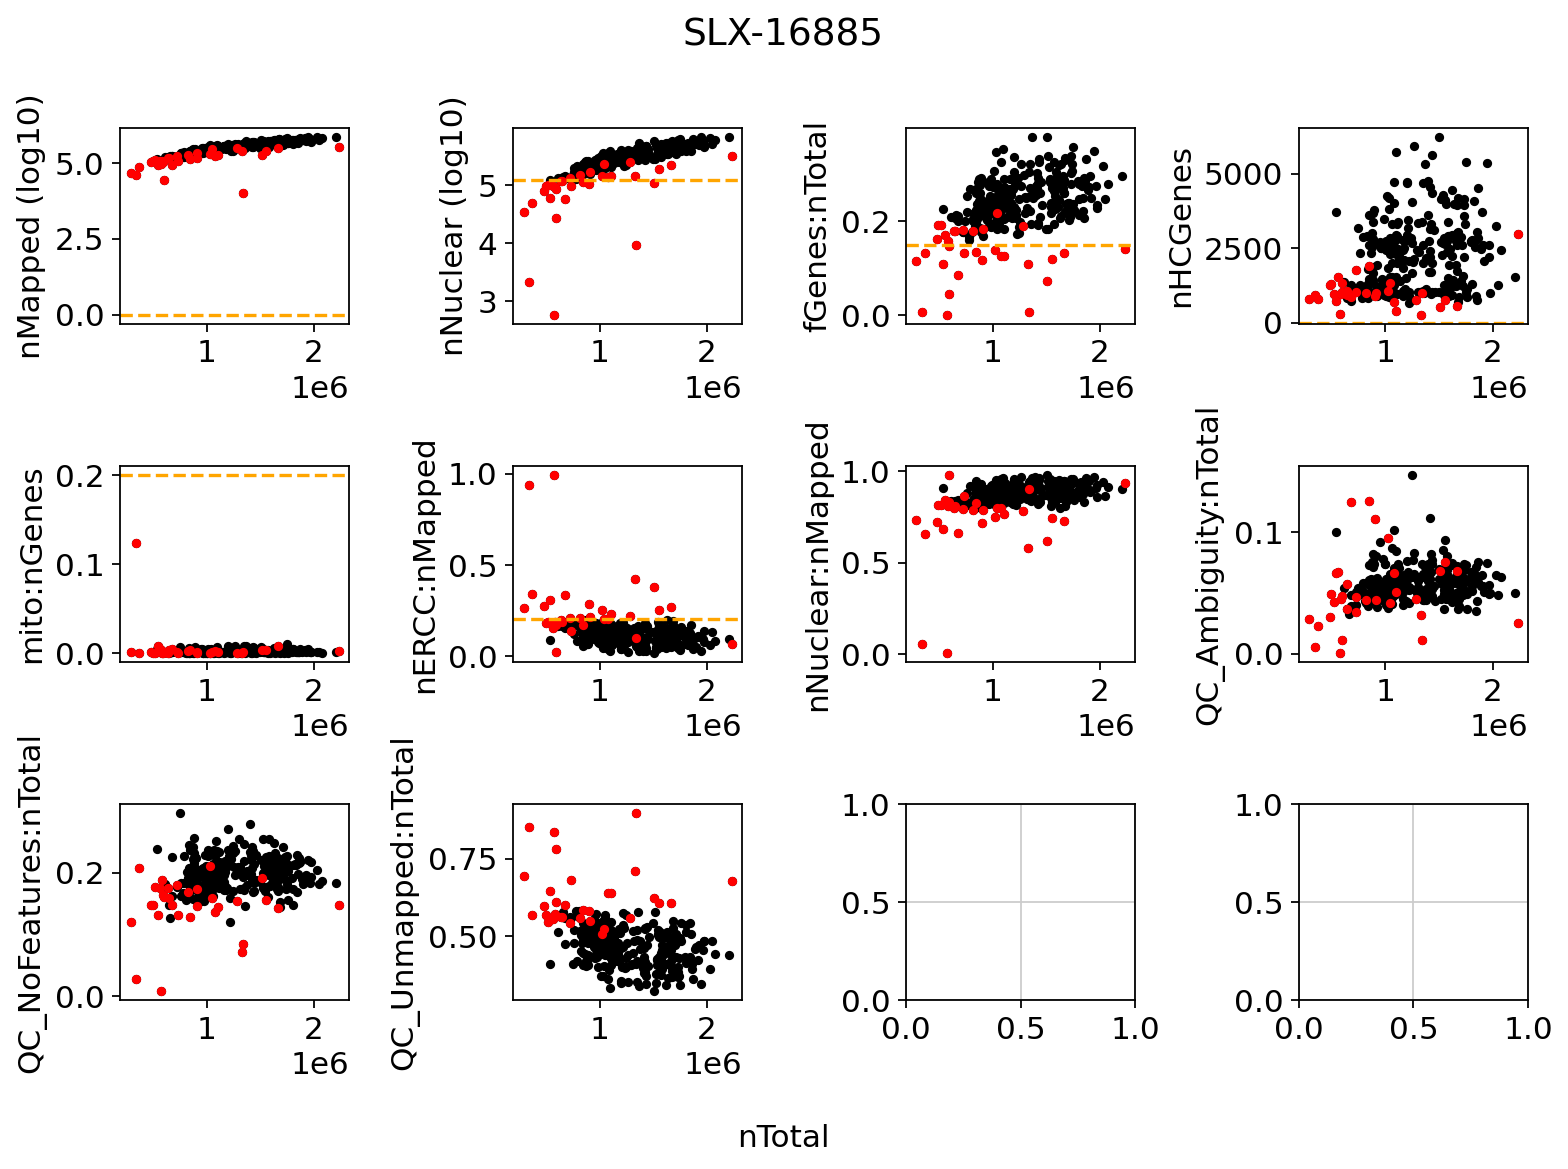

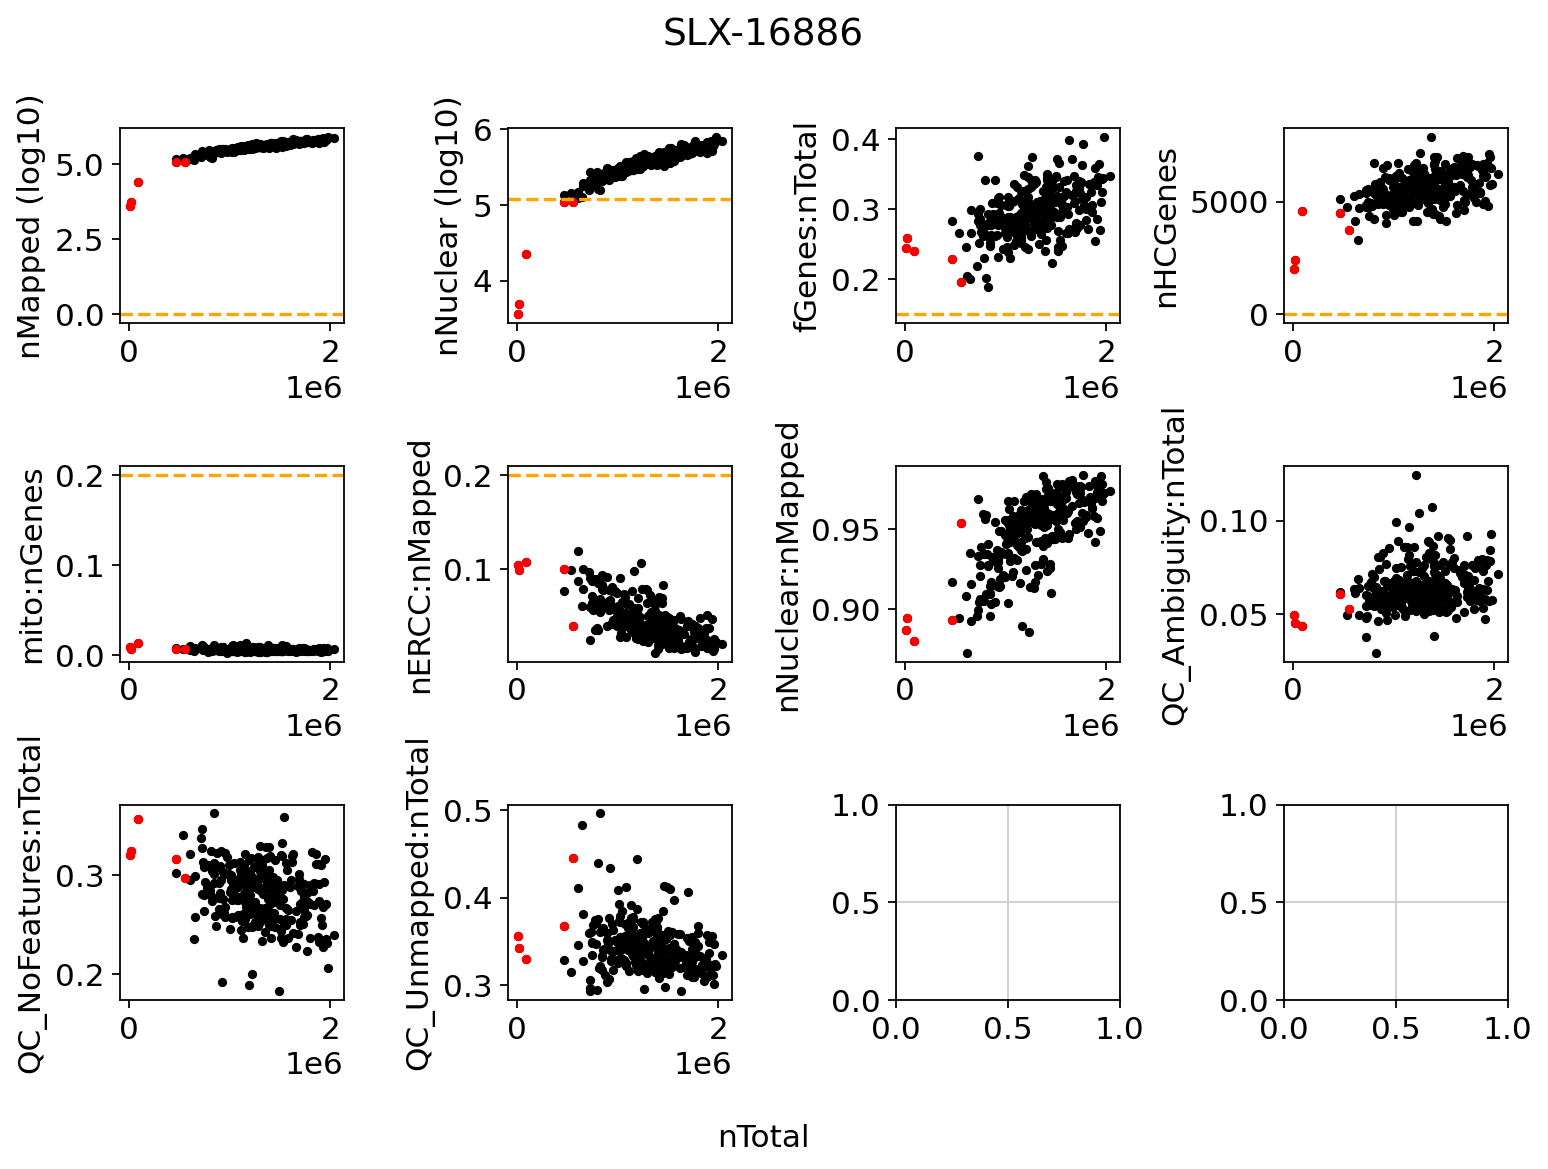

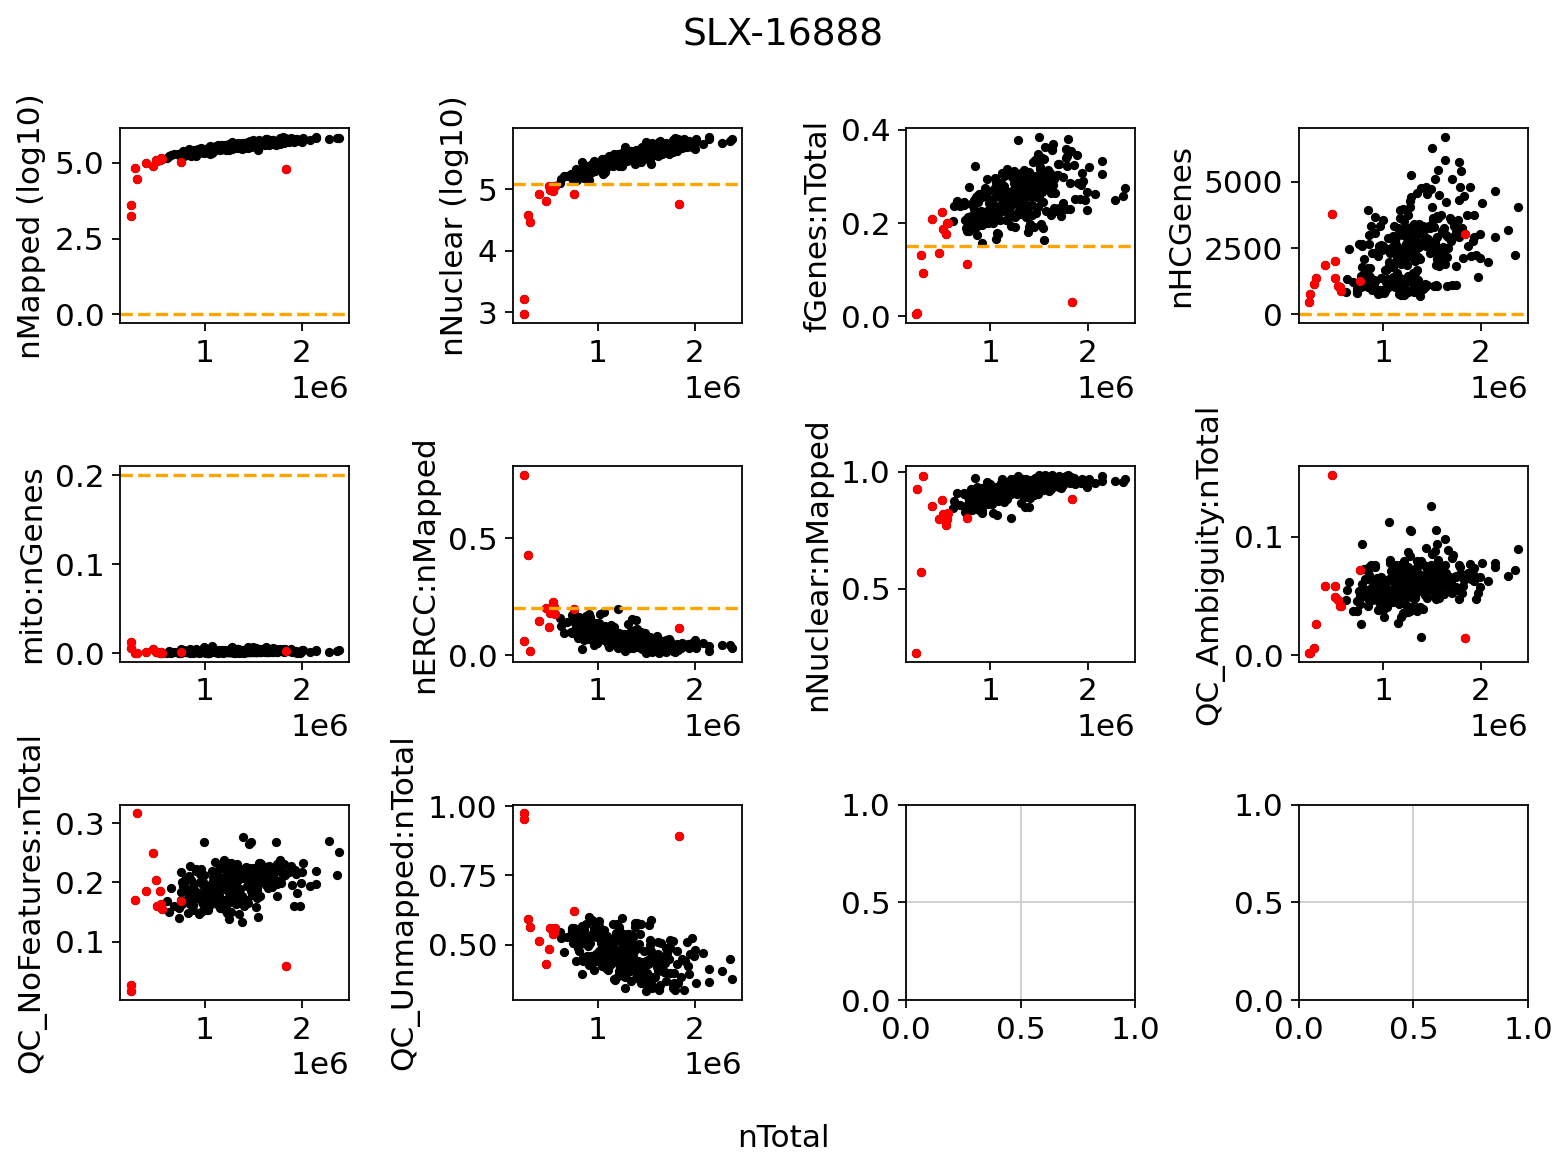

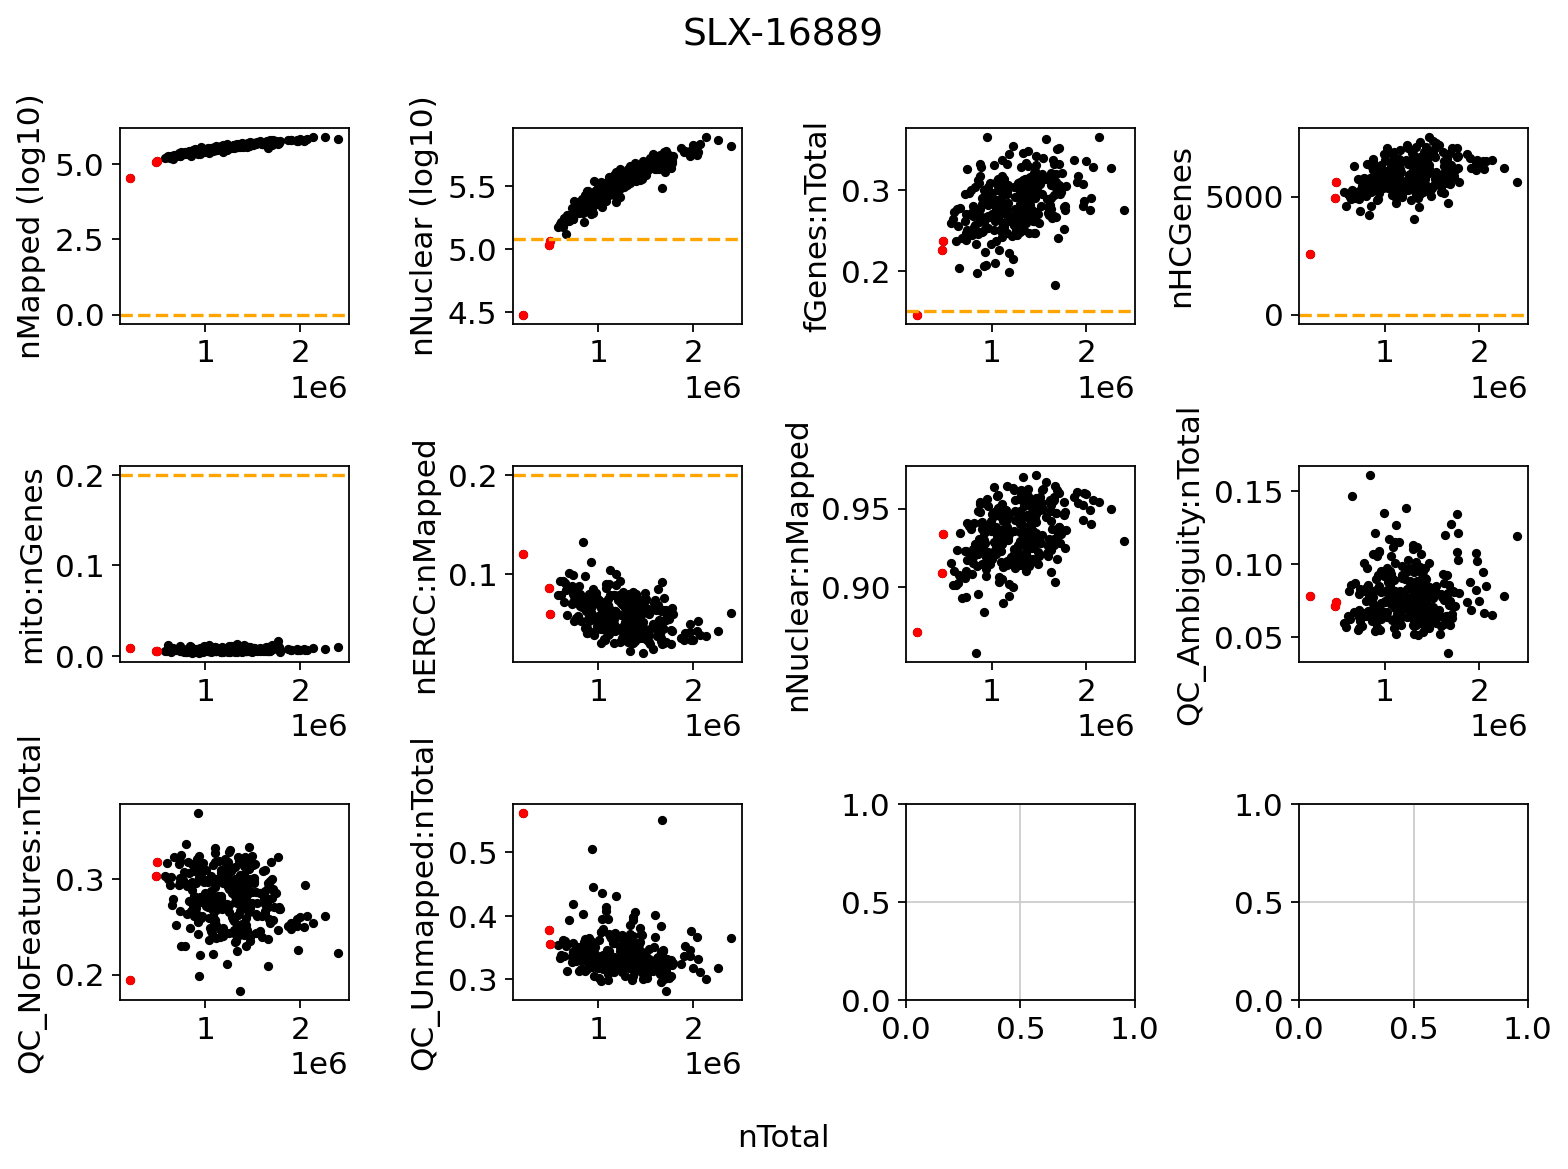

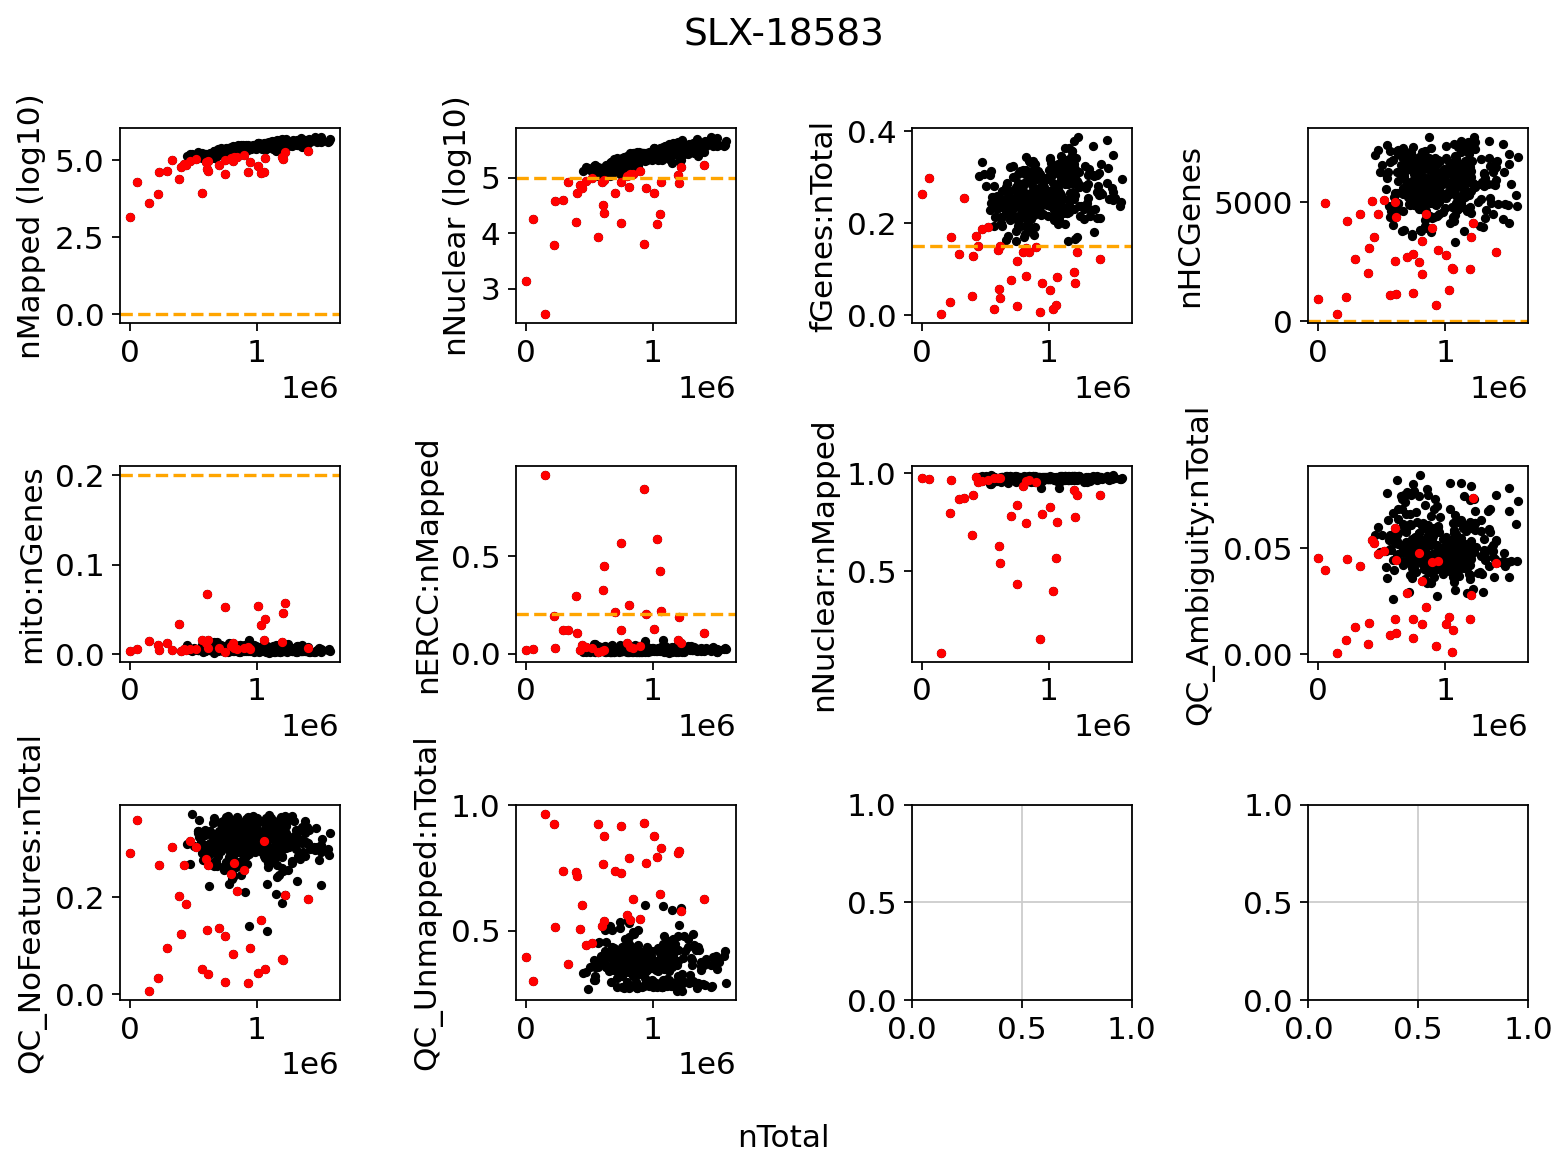

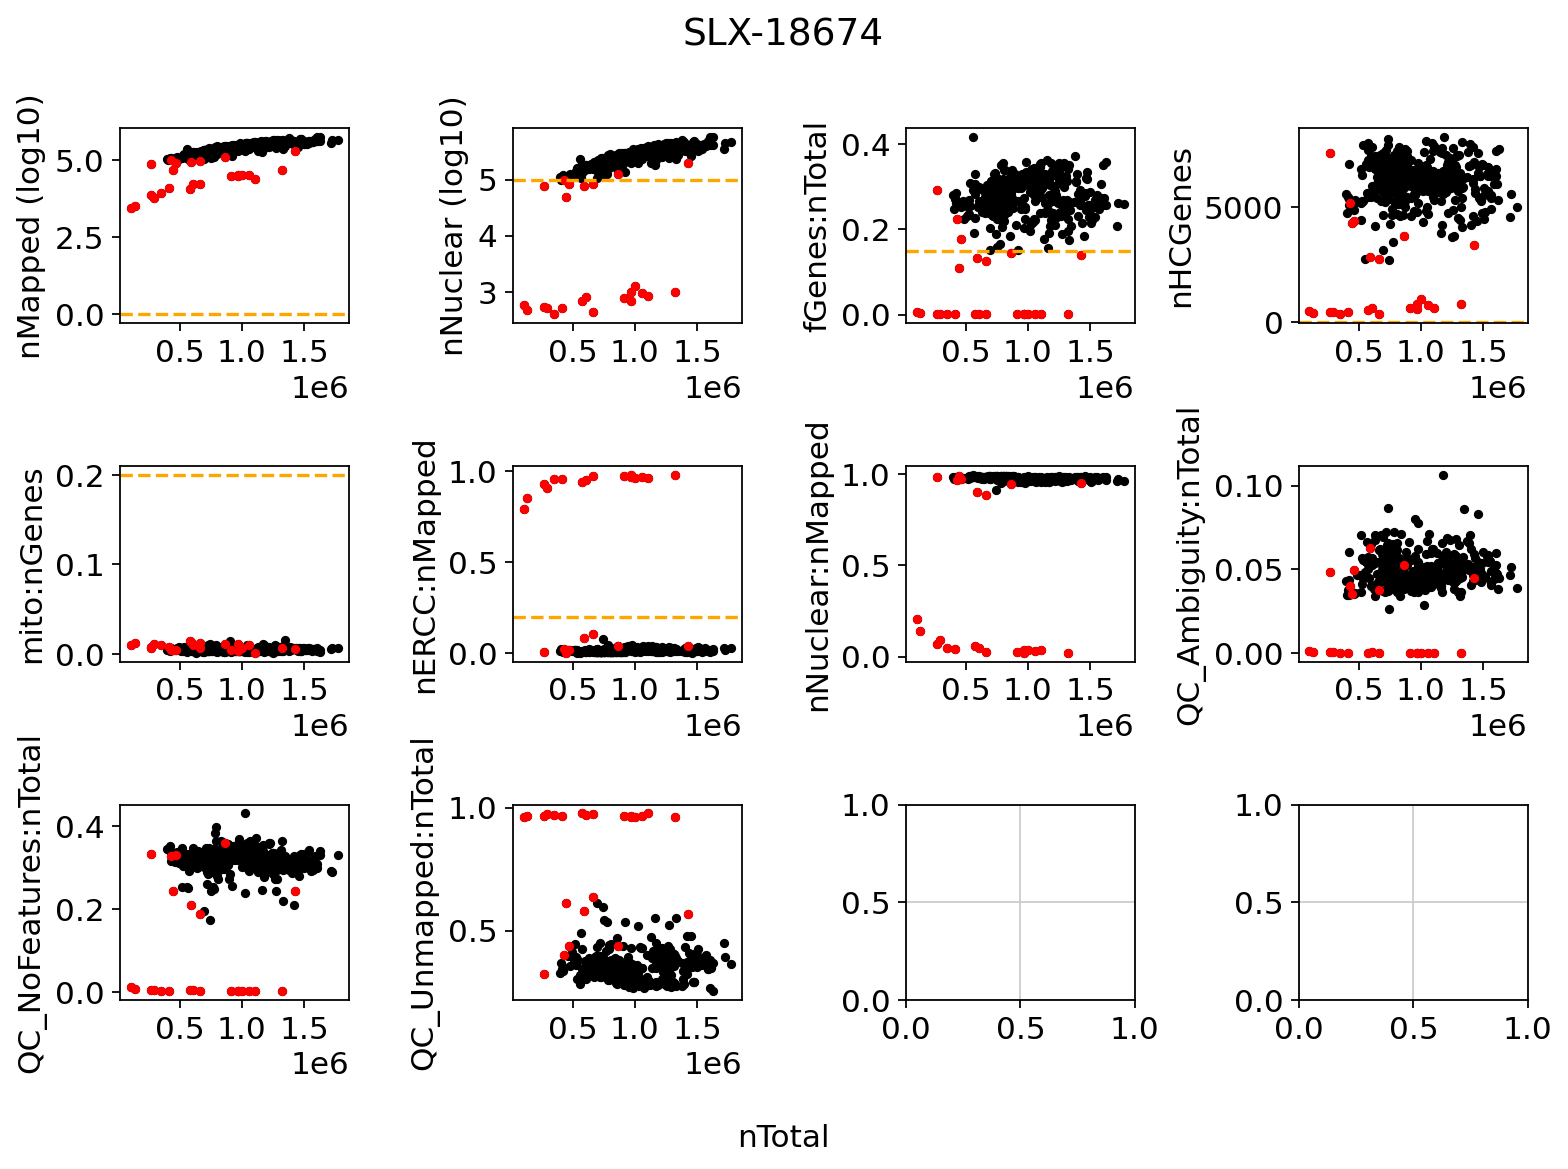

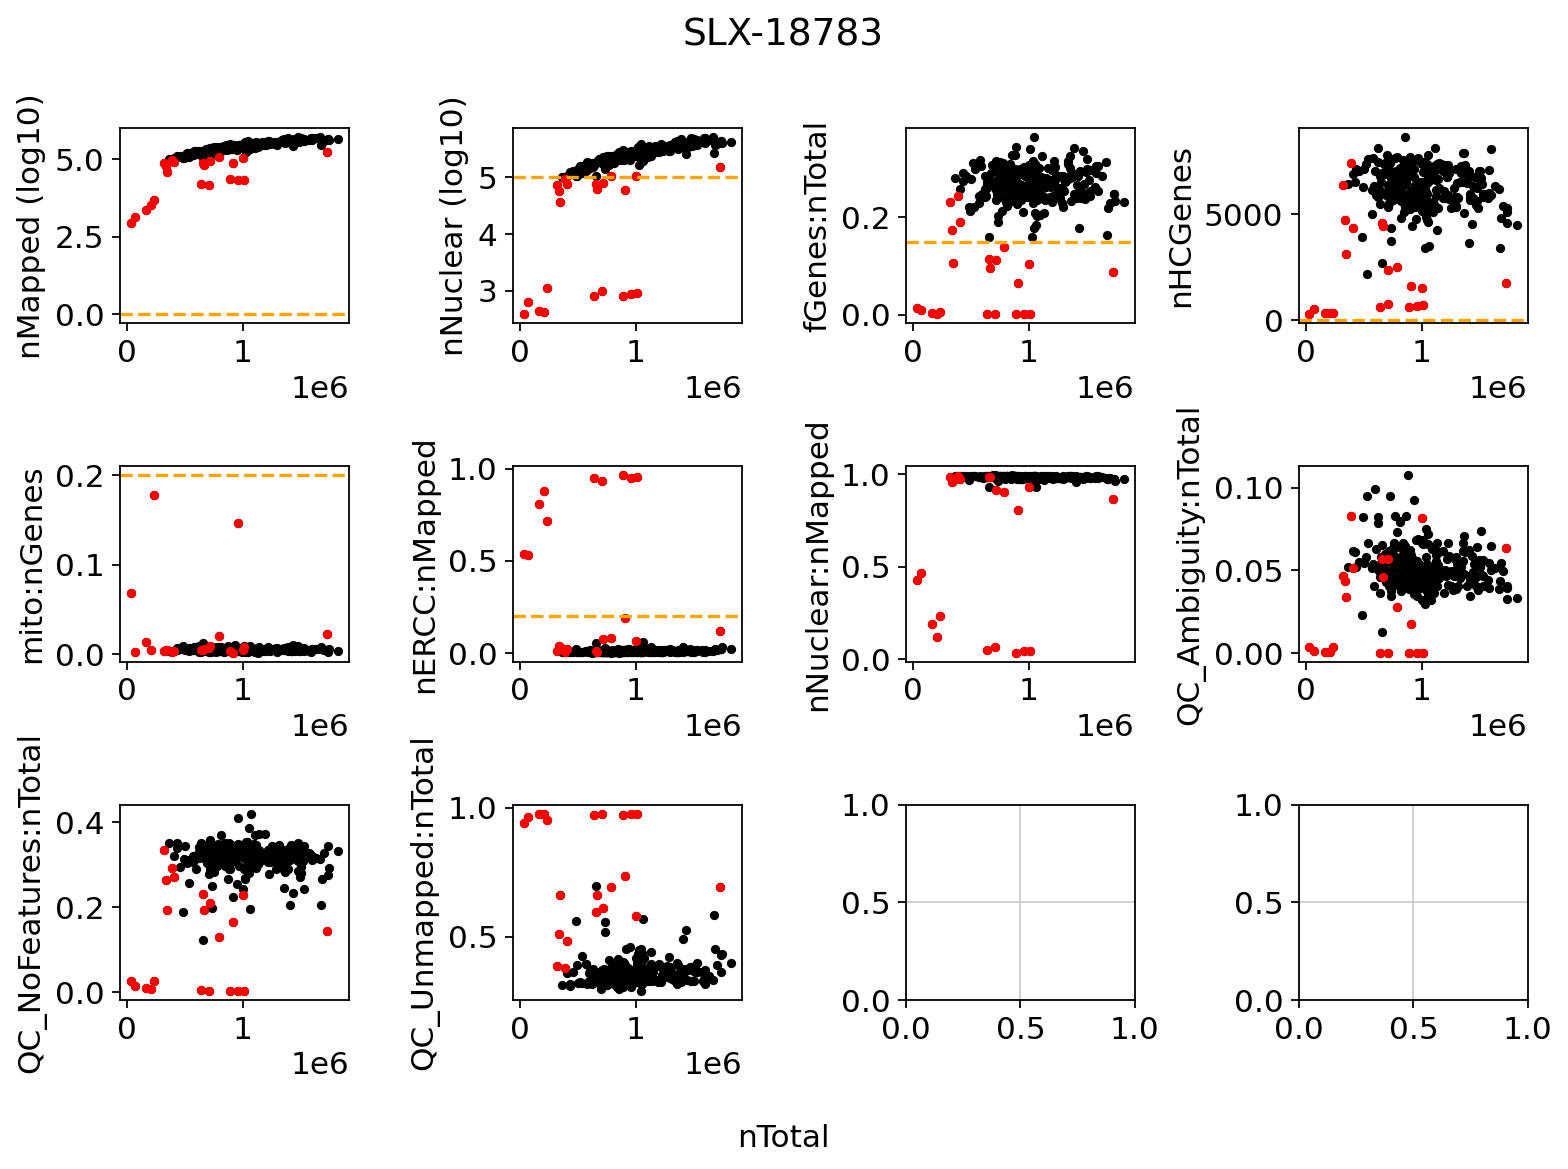

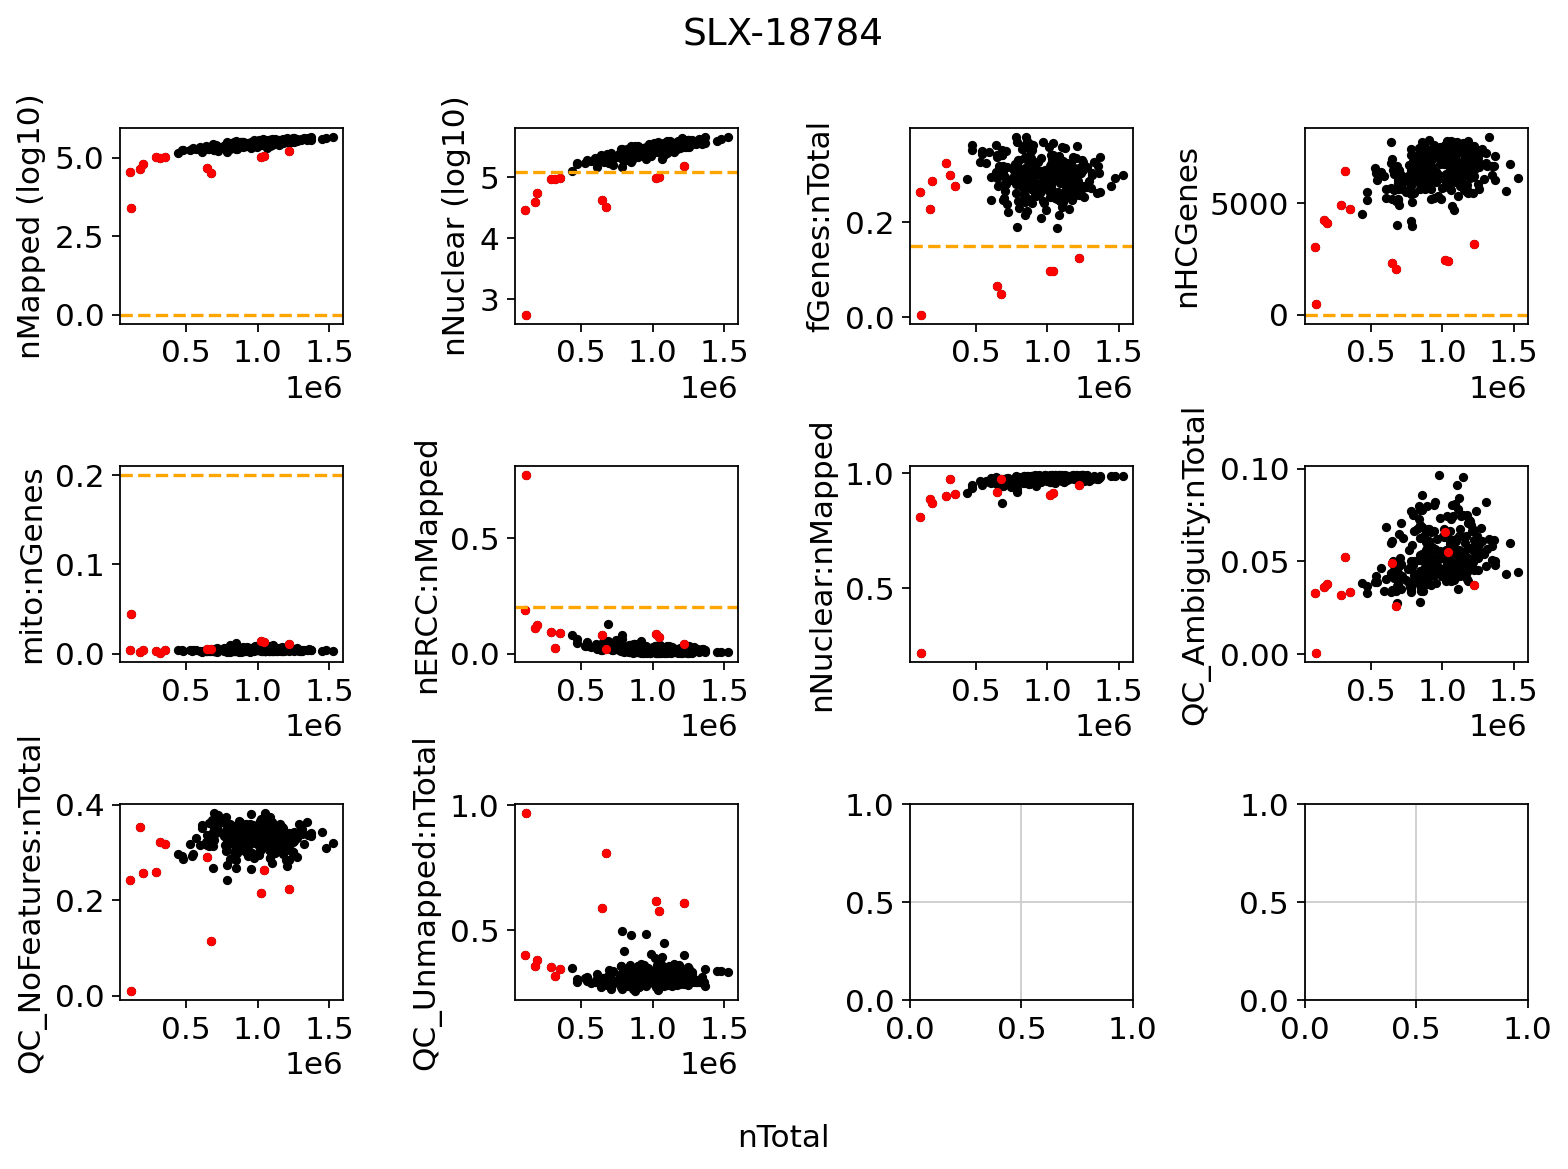

In [27]:
# Do QC for each of the SLXs
SLXs = adata_new.obs['Sequencing_identifier'].value_counts().sort_index().index
print(SLXs)
adata = []
for i in range(len(SLXs)):
    adata_sub = smqpp.smartseq_qc(adata_new[adata_new.obs['Sequencing_identifier']==SLXs[i]],cutoff=cutoff[i], title=SLXs[i])
    adata.append(adata_sub)
    del adata_sub

In [28]:
adata = anndata.AnnData.concatenate(*adata)
adata.obs_names = [x[:-2] for x in adata.obs_names]
adata.obs_names = [x.rstrip('-') for x in adata.obs_names]

In [29]:
print(adata.shape)

(3785, 31053)


In [31]:
adata.obs['Condition'].value_counts()

WT          1420
DKO          710
p53KO        539
TKO          379
Fancd2KO     374
Aldh2KO      363
Name: Condition, dtype: int64

In [30]:
adata.write('./write/patel_smq2_raw.h5ad')

... storing 'Average_pooled_library_length_bp' as categorical
... storing 'Cell_type_general' as categorical
... storing 'Cell_type_subtype' as categorical
... storing 'Condition' as categorical
... storing 'Condition1' as categorical
... storing 'Details' as categorical
... storing 'FACs' as categorical
... storing 'Genotype' as categorical
... storing 'Library_set' as categorical
... storing 'MouseID' as categorical
... storing 'Owner' as categorical
... storing 'Plate_number' as categorical
... storing 'Position_in_96_well_plate_RNAseq' as categorical
... storing 'Position_in_96_well_plate_sorted' as categorical
... storing 'Sequencing_facility_index' as categorical
... storing 'Sequencing_identifier' as categorical
... storing 'Sequencing_index' as categorical
... storing 'Species' as categorical
... storing 'Unique_sample_descriptor' as categorical
... storing 'Gene Type' as categorical
... storing 'Chr' as categorical
... storing 'Start' as categorical
... storing 'End' as catego

In [70]:
# Before further analysis, sort out the categories
adata = sc.read('./write/patel_smq2_raw.h5ad')

In [35]:
cell_type = {'LSK': 'LSK',
            'LSK_bone_marrow': 'LSK',
            'EryA': 'EryA'}
adata.obs['Cell_Type'] = [cell_type[x] for x in adata.obs['Cell_type_general']]

In [37]:
adata.obs['Condition'] = adata.obs['Condition'].astype('category')
adata.obs['Condition'].cat.categories

Index(['Aldh2KO', 'DKO', 'Fancd2KO', 'TKO', 'WT', 'p53KO'], dtype='object')

In [38]:
adata.obs['Condition'] = adata.obs['Condition'].cat.reorder_categories(['WT', 'Aldh2KO', 'Fancd2KO', 'p53KO', 'DKO', 'TKO'])

In [40]:
adata.obs['Condition1'] = adata.obs['Condition1'].astype('category')
adata.obs['Condition1'].cat.categories

Index(['Aldh2KO', 'DKO', 'Fancd2KOhet', 'TKO', 'WT', 'WThet', 'p53KO'], dtype='object')

In [41]:
adata.obs['Condition1'] = adata.obs['Condition1'].cat.reorder_categories(['WT', 'WThet', 'Aldh2KO', 'Fancd2KOhet', 'p53KO', 'DKO', 'TKO'])

In [46]:
pd.crosstab(adata.obs['Condition'], adata.obs['Cell_Type'], margins=True)

Cell_Type  EryA   LSK   All
Condition                  
WT          522   898  1420
Aldh2KO     174   189   363
Fancd2KO    183   191   374
p53KO        86   453   539
DKO         266   444   710
TKO           0   379   379
All        1231  2554  3785

In [79]:
adata.write('./write/patel_smq2_raw.h5ad')

... storing 'Cell_Type' as categorical


# Normalisation

In [31]:
adata = sc.read('./write/patel_smq2_raw.h5ad')

In [32]:
sc.pp.filter_genes(adata, min_cells=1)

filtered out 5660 genes that are detected in less than 1 cells


In [33]:
smqpp.normalise_data(adata)

Calculate SF for genes:
Filtered matrix shape: (3785, 12)
Number of valid means:12
Calculate SF for erccs:
Filtered matrix shape: (3785, 8)
Number of valid means:8


In [86]:
adata.write('./write/patel_smq2_lognorm.h5ad')

... storing 'Cell_Type' as categorical


# Downstream analysis 
## Cell Cycle Assignment

In [80]:
# here start cell cycle assignment with log norm counts
adata = sc.read('./write/patel_smq2_lognorm.h5ad')

In [37]:
# Scaling must be done before scoring
sc.pp.scale(adata)

In [38]:
cell_cycle_genes = [x.strip().title() for x in open('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

97


In [39]:
# reformat gene list
def reformat_GN(s):
    s = s[0].upper() + s[1:].lower()
    return(s)

In [40]:
cell_cycle_genes = [reformat_GN(x) for x in cell_cycle_genes]

In [41]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print('Number of s_genes: '+str(len(s_genes)))
print('Number of g2m_genes: '+str(len(g2m_genes)))
print('Total number of cell cycle genes: '+str(len(cell_cycle_genes)))

Number of s_genes: 43
Number of g2m_genes: 54
Total number of cell cycle genes: 94


In [42]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    386 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    342 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [43]:
adata.obs['phase'].value_counts().sort_index()

G1     1327
G2M    1276
S      1182
Name: phase, dtype: int64

In [44]:
# save cell cycle assignments
adata.obs[['phase', 'S_score', 'G2M_score']].to_csv('cell_cycle_results.txt')

# Look at sexual effect

In [2]:
# start from log norm counts again
adata = sc.read('./write/patel_smq2_lognorm.h5ad')

In [4]:
adata.obs['Cond'] = adata.obs['Condition'].astype(str)+'_'+adata.obs['MouseID'].astype(str)
adata.obs['Cond'] = adata.obs['Cond'].astype('category')
adata.obs['Cond'] = adata.obs['Cond'].cat.reorder_categories(np.sort(adata.obs['Cond'].cat.categories))

In [62]:
adata.obs['Cond'].value_counts()

WT_KJGV1.8f        193
TKO_KJBX5.3f       190
TKO_KJBX8.3a       189
Fancd2KO_18196     189
WT_18197           186
WT_28178           185
Fancd2KO_18194     185
WT_30410           184
Aldh2KO_18193      182
p53KO_KJBX10.1B    182
Aldh2KO_14804      181
p53KO_21481        181
DKO_23325          180
DKO_32124          178
WT_24927           177
DKO_KJBX7.3b       177
p53KO_KJBX10.2d    176
WT_28175           176
WT_14806           176
DKO_21509          175
WT_KJBX10.2b       143
Name: Cond, dtype: int64

In [19]:
df_sub = adata.obs[['Cond']].copy()
df_sub['Xist'] = adata.raw[:,'Xist'].X.flatten()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 <a list of 21 Text major ticklabel objects>)

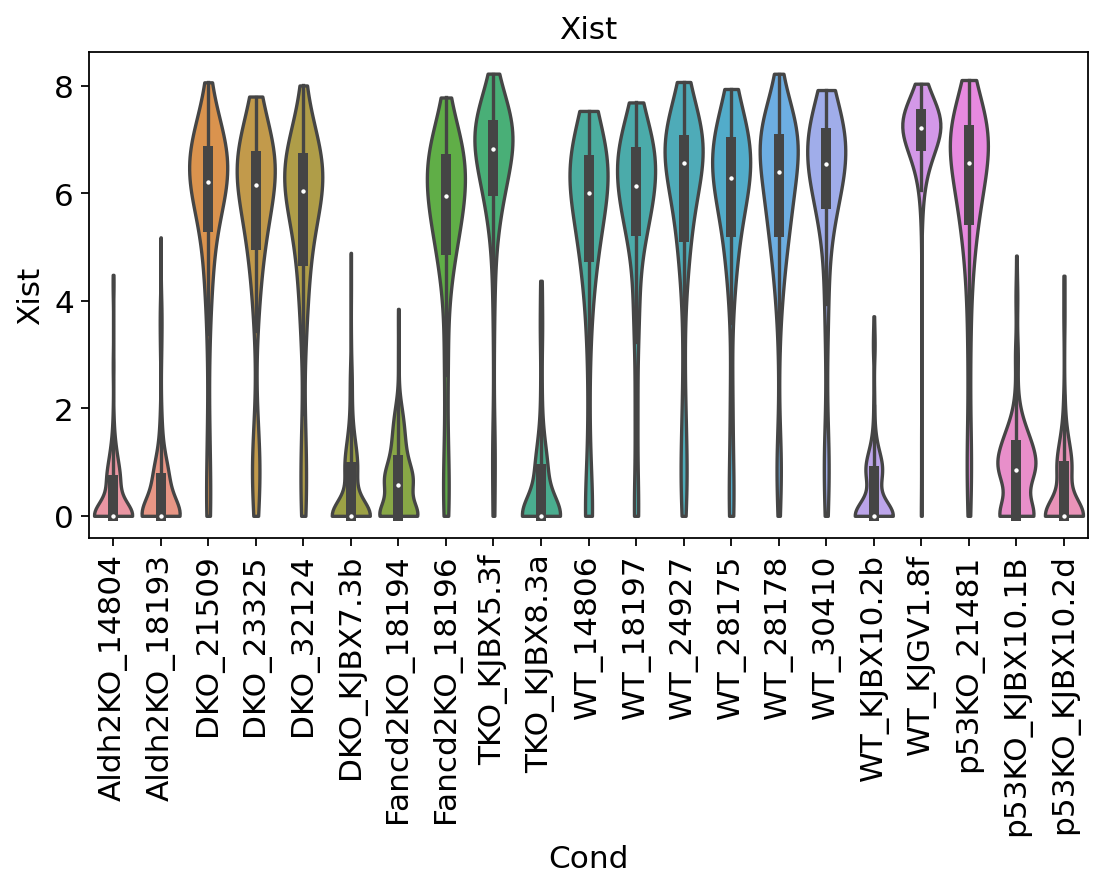

In [20]:
import seaborn as sns
plt.figure(figsize=(8,4))
ax = sns.violinplot(x='Cond', y='Xist', data=df_sub, scale='width', cut=0)
ax.grid(False)
ax.set_title('Xist')
plt.xticks(rotation=90)

In [22]:
ychrG = np.genfromtxt('ychrG.txt', dtype=str)
df_sub = adata.obs[['Cond']].copy()
df_sub['YchrG'] = np.mean(adata.raw[:,ychrG].X, axis=1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 <a list of 21 Text major ticklabel objects>)

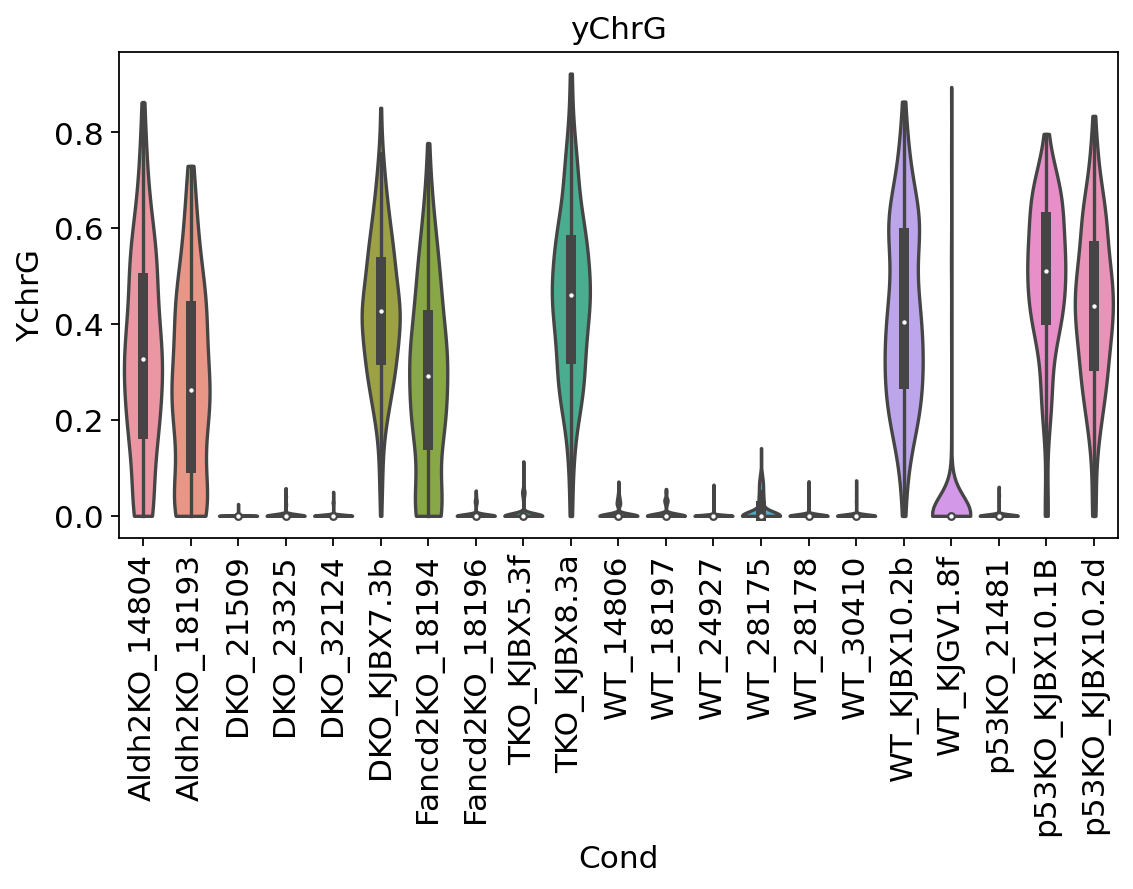

In [23]:
import seaborn as sns
plt.figure(figsize=(8,4))
ax = sns.violinplot(x='Cond', y='YchrG', data=df_sub, scale='width', cut=0)
ax.grid(False)
ax.set_title('yChrG')
plt.xticks(rotation=90)

In [52]:
# Save the sex obs
sex = {'14804':'M',
      '18193': 'M',
      '21509': 'F',
      '23325': 'F',
      '32124': 'F',
      'KJBX7.3b': 'M',
      '18194': 'M',
      '18196': 'F',
      'KJBX5.3f': 'F',
      'KJBX8.3a': 'M',
      '14806': 'F',
      '18197': 'F',
      '24927': 'F',
      '28175': 'F',
      '28178': 'F',
      '30410': 'F',
      'KJBX10.2b': 'M',
      'KJGV1.8f': 'F',
      '21481': 'F',
       'KJBX10.1B': 'M',
       'KJBX10.2d': 'M'
      }
adata.obs['Sex'] = [sex[x] for x in adata.obs['MouseID']]

In [53]:
adata.obs['Sex'].value_counts()

F    2370
M    1415
Name: Sex, dtype: int64

In [54]:
adata.write('./write/patel_smq2_lognorm.h5ad')

... storing 'Sex' as categorical


Sex will be one of the confounding factors.

# Look at the KO genes

In [47]:
adata = sc.read('./write/patel_smq2_lognorm.h5ad')

In [64]:
adata.obs['Cond1'] = adata.obs['Cell_Type'].astype(str)+'_'+adata.obs['Cond'].astype(str)
adata.obs['Cond1'] = adata.obs['Cond1'].astype('category')
adata.obs['Cond1'] = adata.obs['Cond1'].cat.reorder_categories(np.sort(adata.obs['Cond1'].cat.categories))

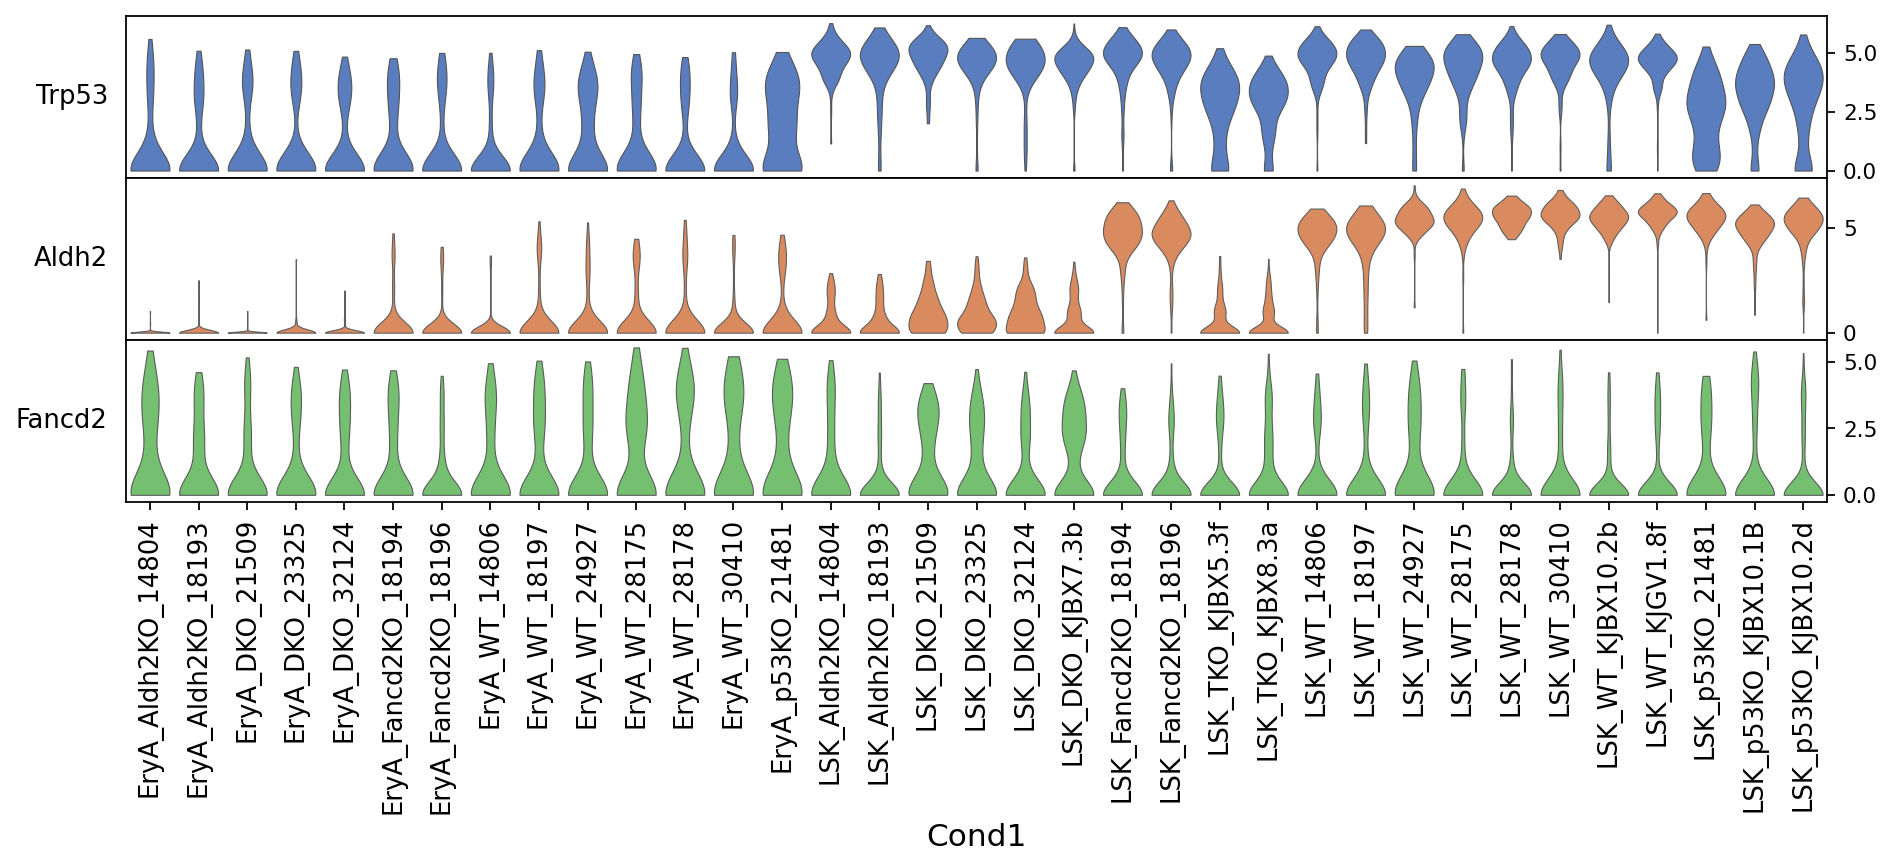

In [66]:
sc.pl.stacked_violin(adata, var_names=['Trp53', 'Aldh2', 'Fancd2'], groupby='Cond1', swap_axes=True, figsize=(15,4))

# Select Highly Variable Genes

In [90]:
# start from log norm counts again
adata = sc.read('./write/patel_smq2_lognorm.h5ad')

In [ ]:
adata.raw = adata

In [91]:
# save the cell cycle results
cell_cycle_results = pd.read_csv('cell_cycle_results.txt', index_col=0)
adata.obs = pd.concat([adata.obs, cell_cycle_results], axis=1)

In [92]:
smqpp.tech_var(adata, useERCC=True) 

MeanForFit:  10.574196869158609
30
Length of HVGs: 4952


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/smqpp/__init__.py:483: RuntimeWarning: invalid value encountered in true_divide
  cv2s = (sStd/sMean)**2
/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/smqpp/__init__.py:488: RuntimeWarning: invalid value encountered in greater
  meanForFit = np.quantile(sMean[cv2s>cvThresh], quant)
/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


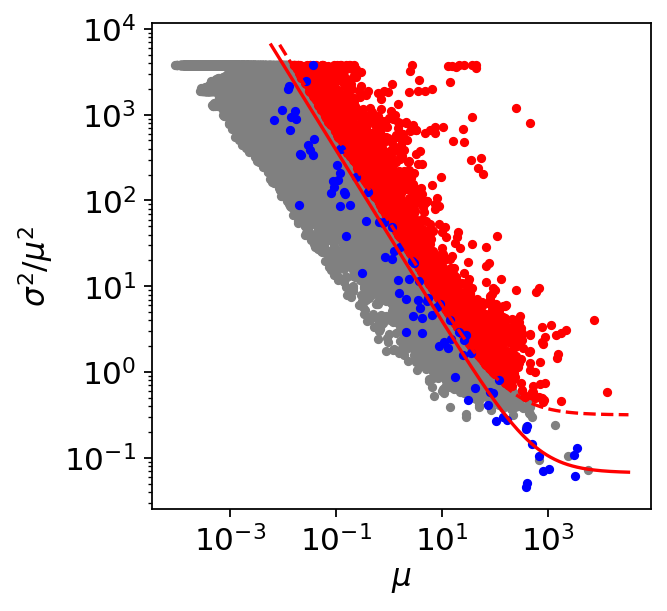

In [93]:
smqpp.plot_tech_var(adata)

In [94]:
adata.shape

(3785, 25393)

In [95]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [96]:
adata.shape

(3785, 4952)

In [97]:
# scale for pca
sc.pp.scale(adata)

# Visualization

computing PCA
    with n_comps=50
    finished (0:00:01)


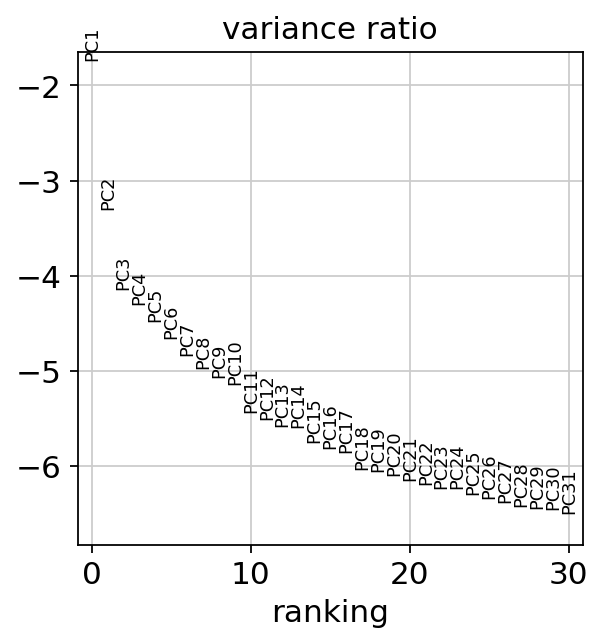

In [98]:
# Try different visualisations
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [99]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.tsne(adata)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:22)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:20)


In [100]:
adata.write('./write/patel_smq2_processed.h5ad')

... storing 'phase' as categorical


In [103]:
keys2plot = ['batch', 'n_counts', 'n_genes', 'phase',  'Cell_Type', 'Sex', 'Condition', 'Condition1', 'MouseID']

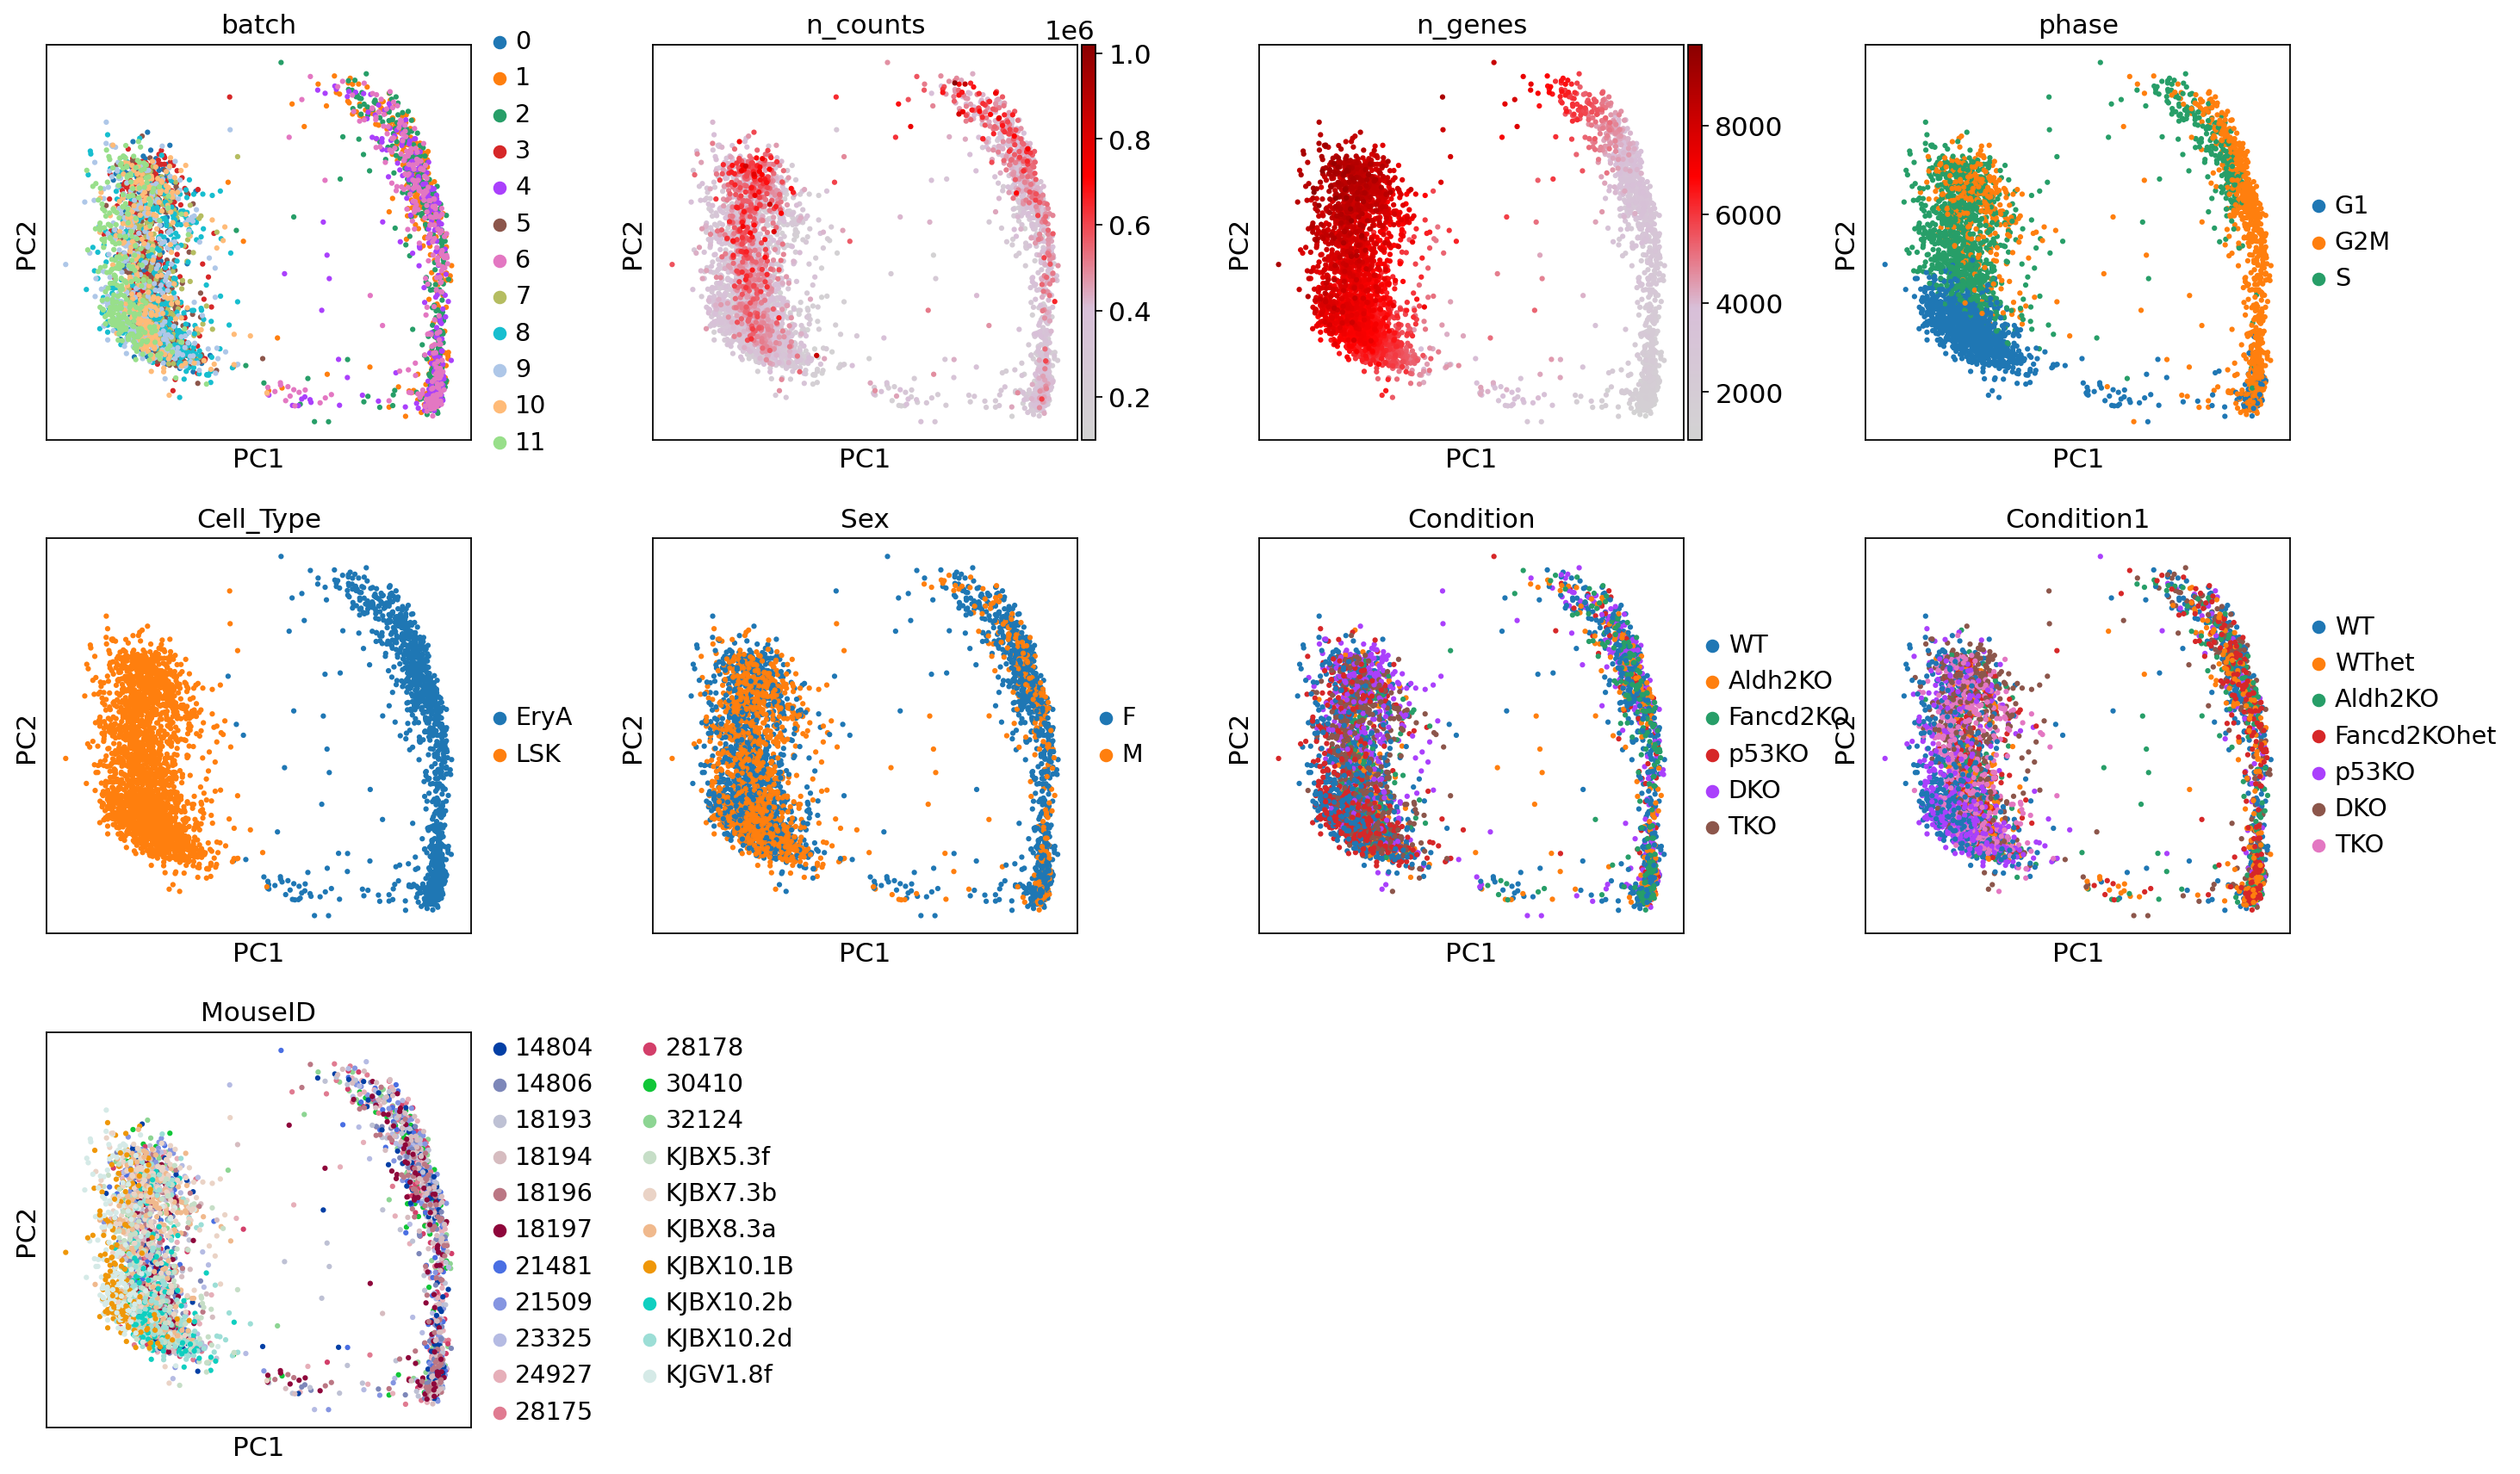

In [104]:
sc.pl.pca_scatter(adata, color=keys2plot, color_map=cmap, wspace = 0.3)

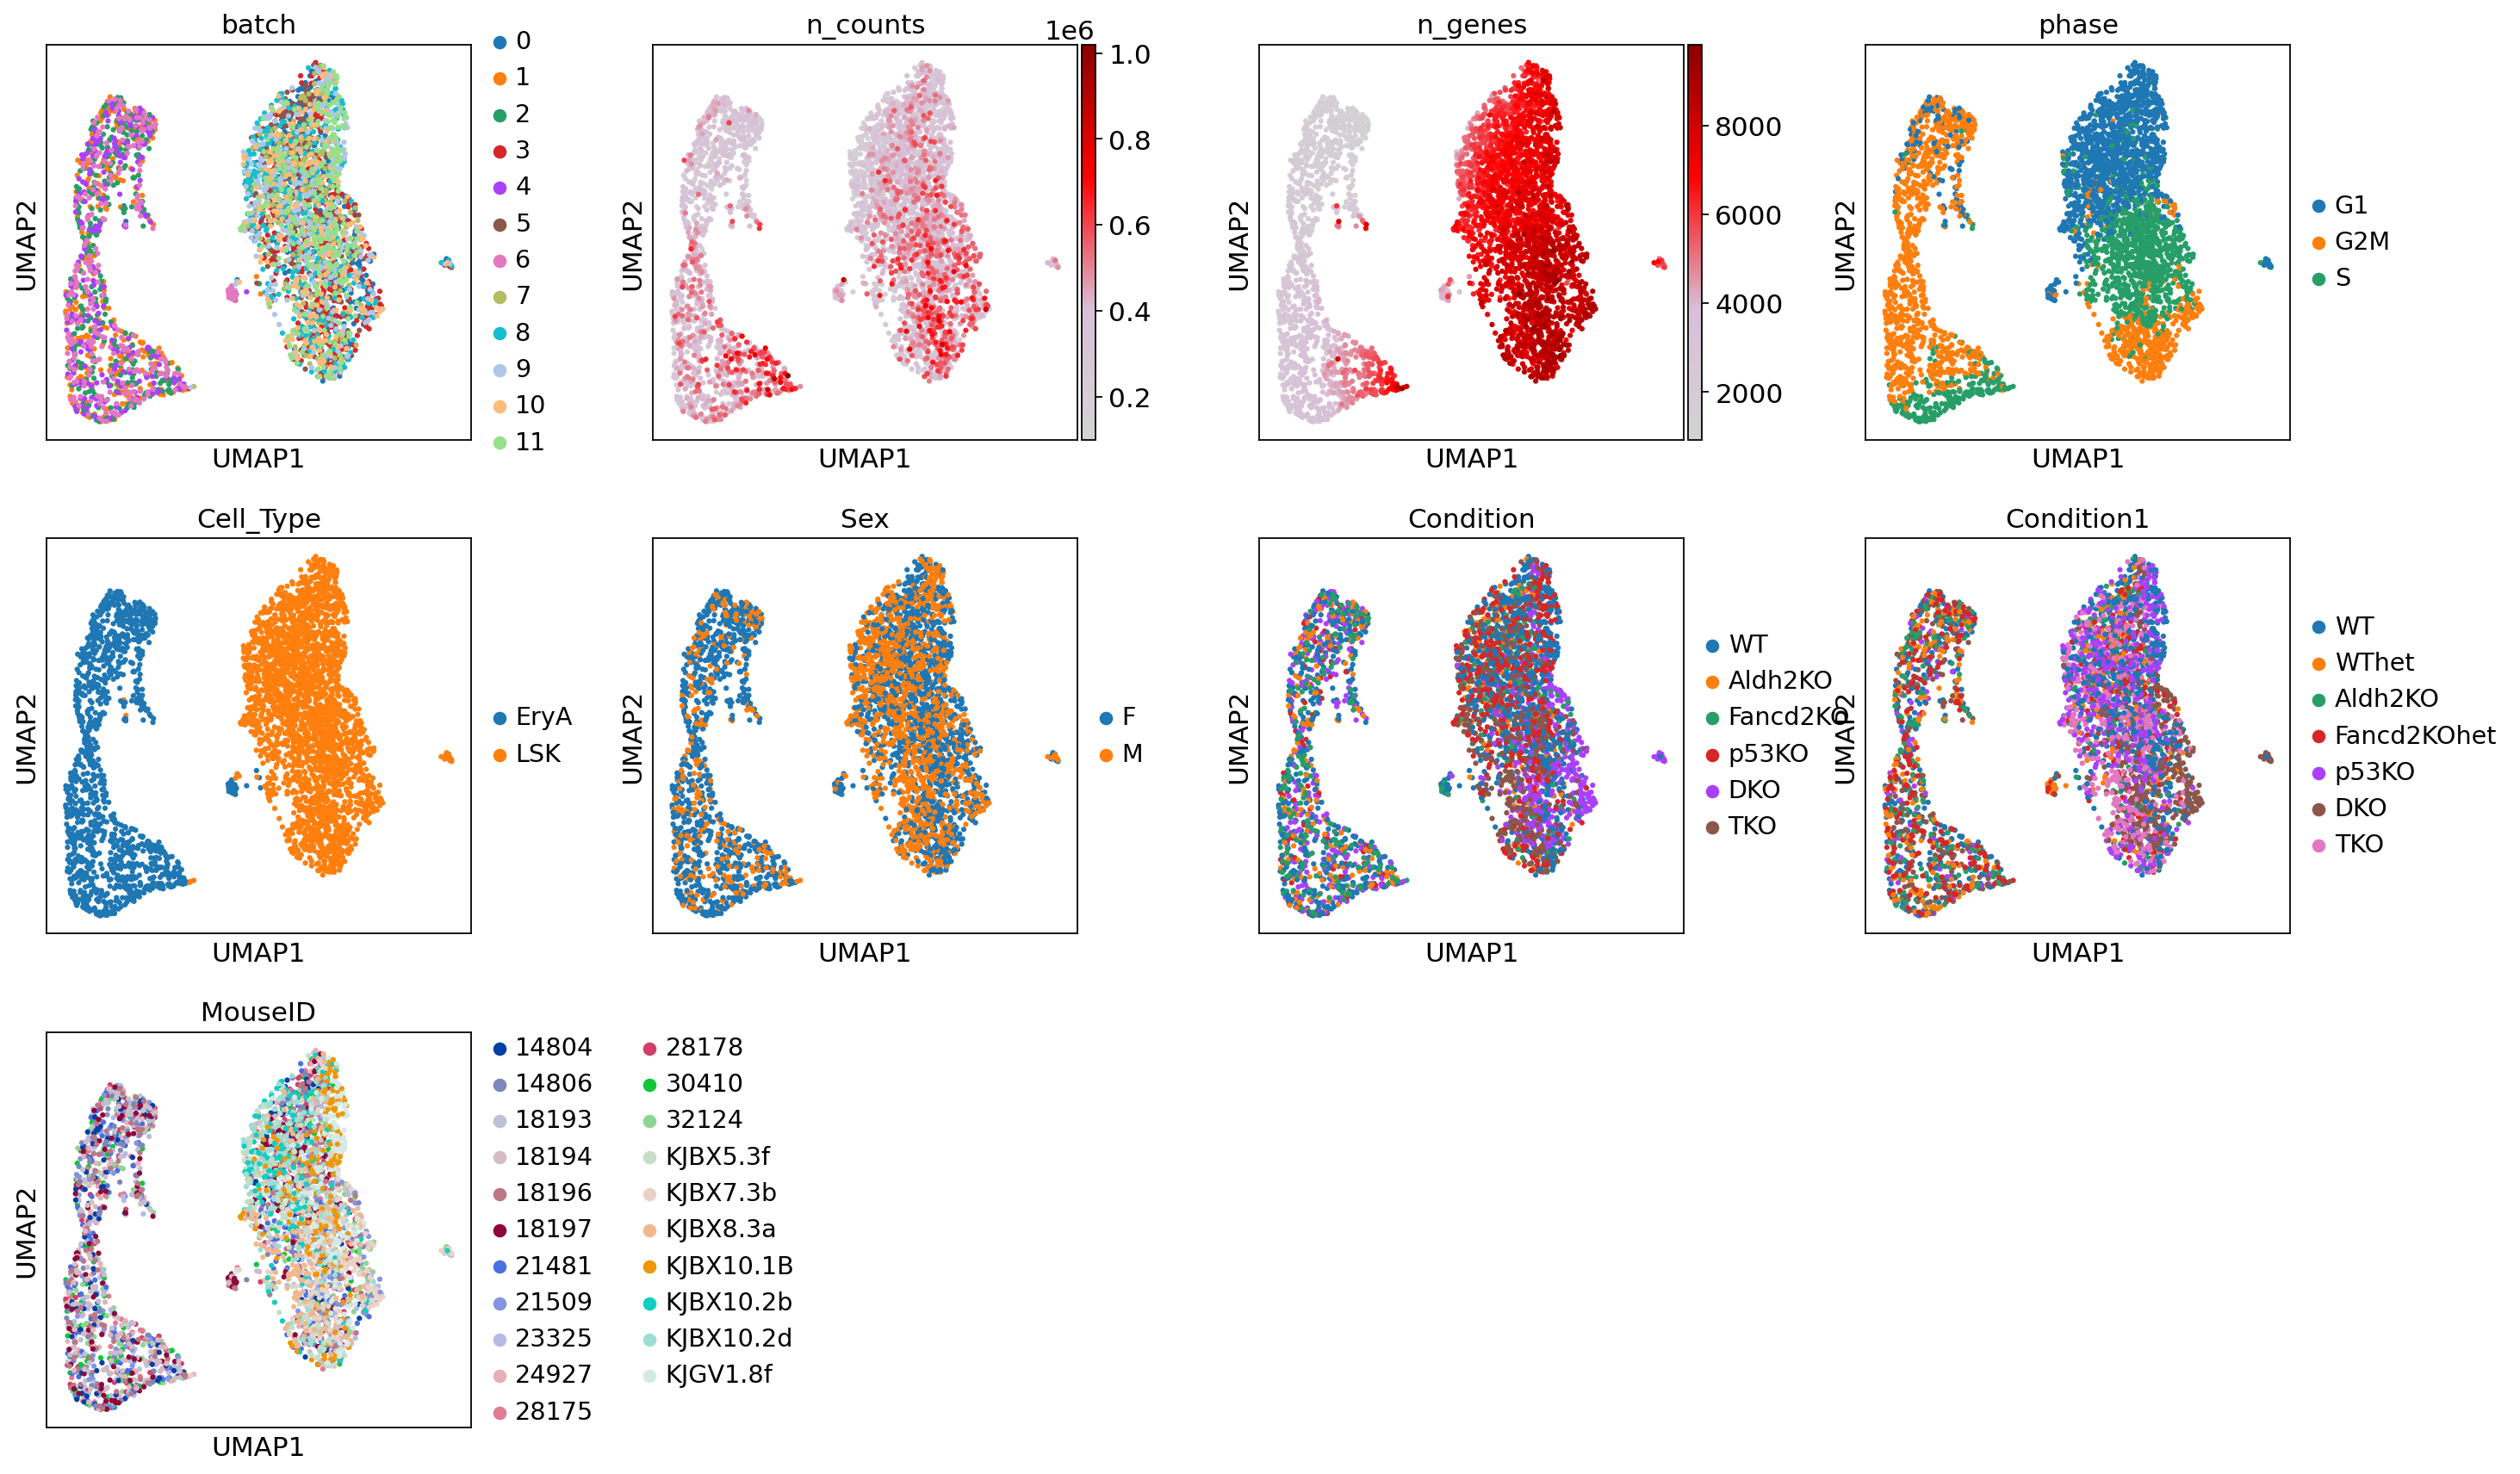

In [105]:
sc.pl.umap(adata, color=keys2plot, color_map=cmap, wspace = 0.3)

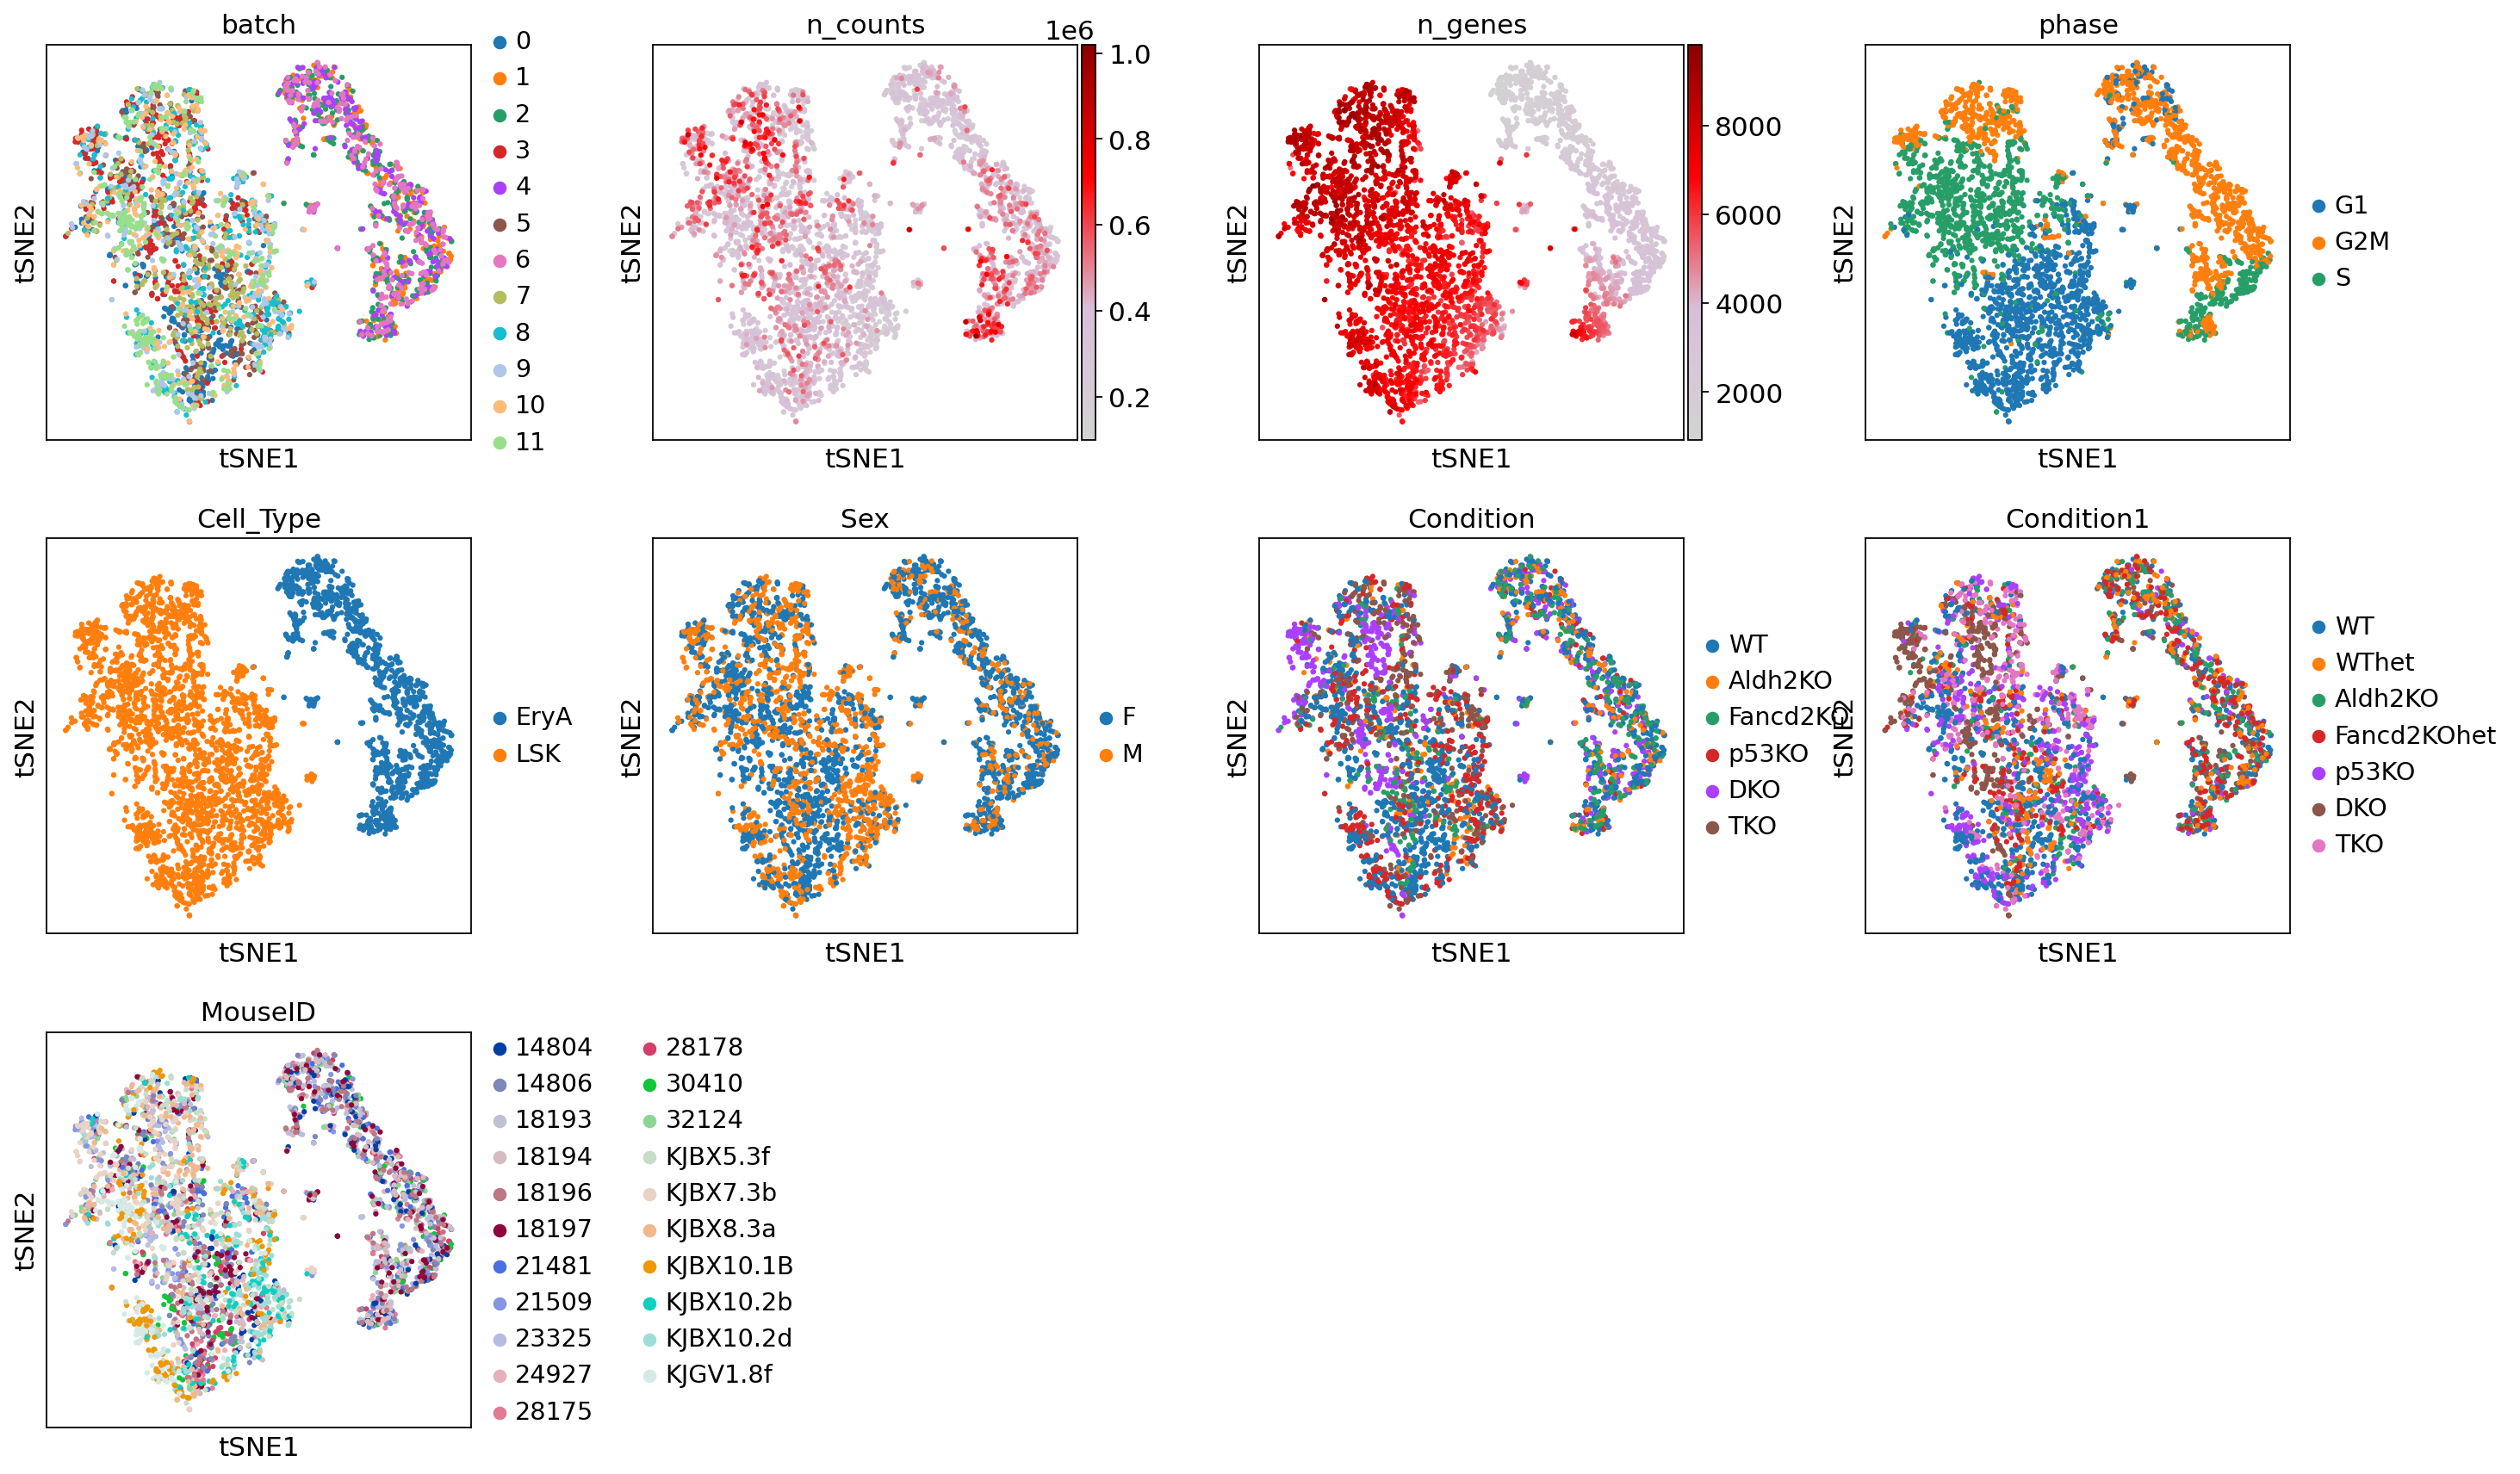

In [106]:
sc.pl.tsne(adata, color=keys2plot, color_map=cmap, wspace = 0.3)

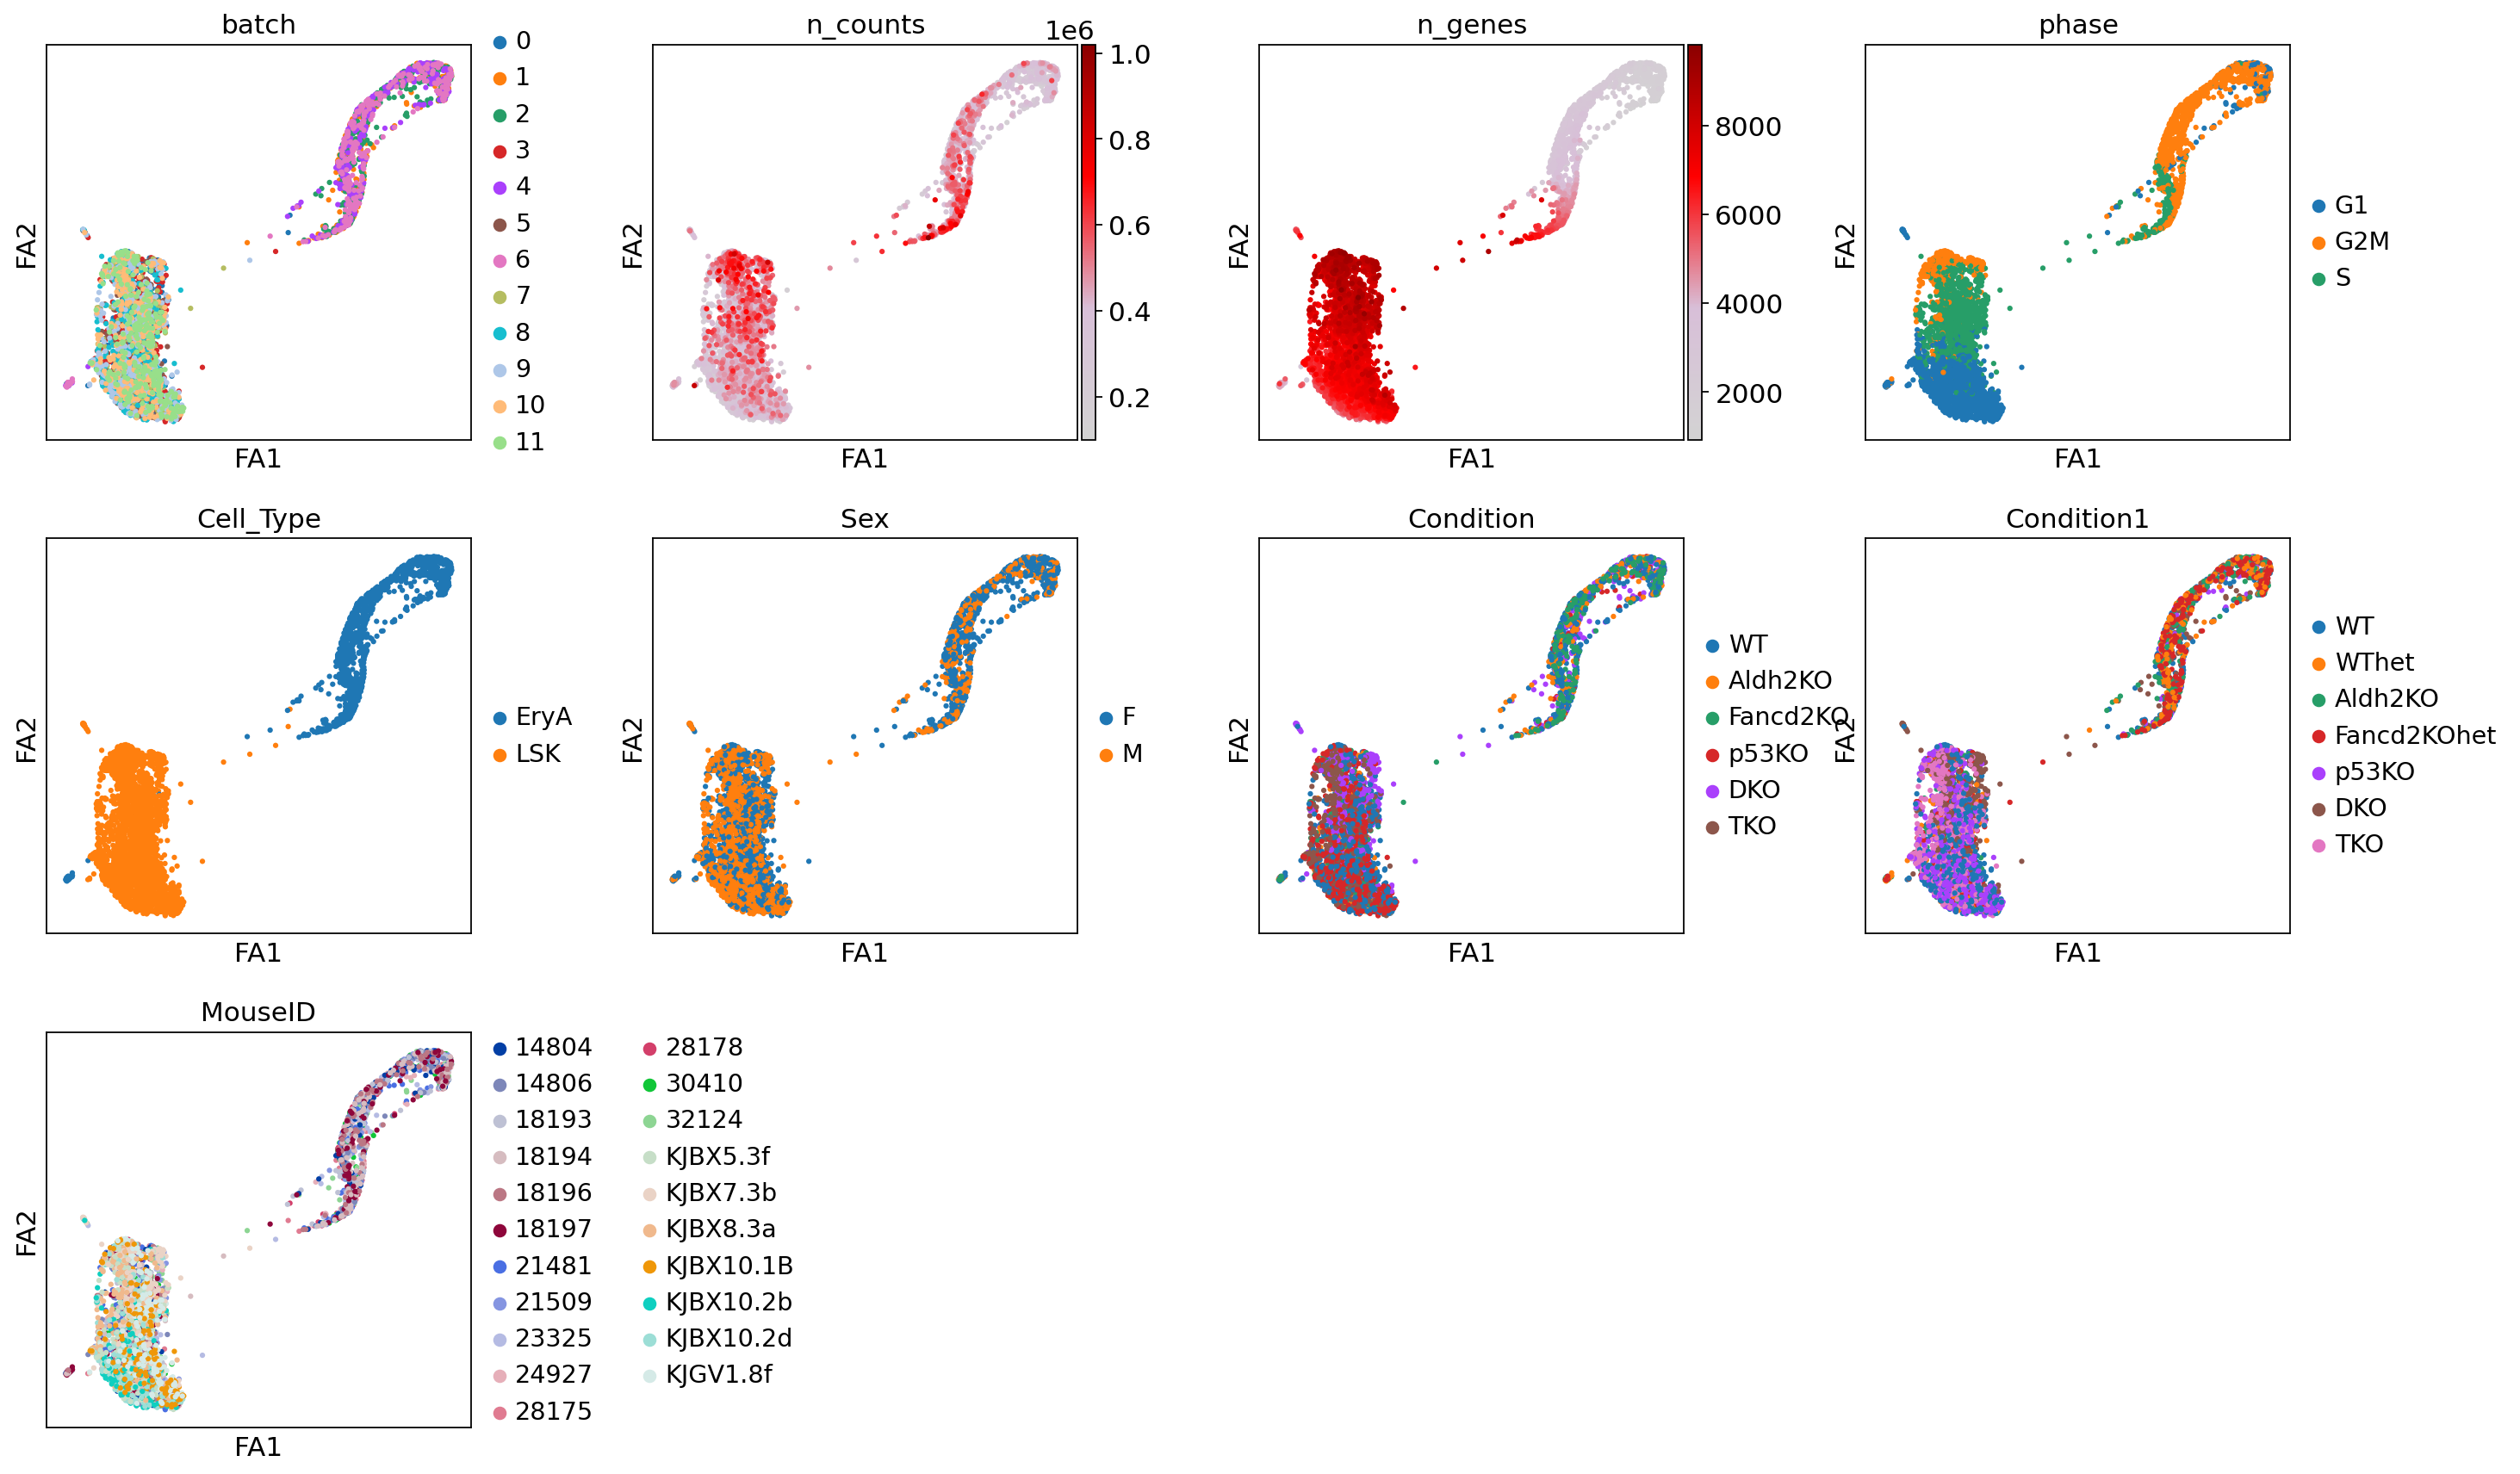

In [107]:
sc.pl.draw_graph(adata, color=keys2plot, color_map=cmap, wspace = 0.3)

# Split data 

In [3]:
adata = sc.read('./write/patel_smq2_processed.h5ad')

In [4]:
adata_raw = sc.read('./write/patel_smq2_raw.h5ad')

In [5]:
adata_raw.obs = adata.obs

In [8]:
adata_LSK = adata_raw[adata_raw.obs['Cell_Type'] == 'LSK', :].copy()
adata_EryA = adata_raw[adata_raw.obs['Cell_Type'] == 'EryA', :].copy()

In [10]:
print(adata.shape)
print(adata_LSK.shape)
print(adata_EryA.shape)

(3785, 4952)
(2554, 31053)
(1231, 31053)


In [9]:
adata_LSK.write('./write/patel_smq2_LSK_raw.h5ad')
adata_EryA.write('./write/patel_smq2_EryA_raw.h5ad')

In [38]:
# quick check data
adata_LSK = sc.read('./write/patel_smq2_LSK_raw.h5ad')

In [11]:
adata_LSK.obs['Sequencing_identifier'].value_counts()

SLX-14256    369
SLX-14789    367
SLX-18674    360
SLX-18583    348
SLX-16889    285
SLX-16886    283
SLX-18784    276
SLX-18783    266
Name: Sequencing_identifier, dtype: int64

In [13]:
print(adata_LSK.obs_keys())

['Average_pooled_library_length_bp', 'Cell_type_general', 'Cell_type_subtype', 'Condition', 'Condition1', 'Details', 'FACs', 'Genotype', 'Library_set', 'MouseID', 'Number_of_lanes', 'Owner', 'Plate_number', 'Pool_size', 'Position_in_96_well_plate_RNAseq', 'Position_in_96_well_plate_sorted', 'QC_Unassigned_Ambiguity', 'QC_Unassigned_NoFeatures', 'QC_Unassigned_Unmapped', 'Sequencing_facility_index', 'Sequencing_identifier', 'Sequencing_index', 'Species', 'Unique_sample_descriptor', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'slx', 'sf_gene', 'sf_ercc', 'Sex', 'Cell_Type', 'phase', 'S_score', 'G2M_score']


In [19]:
adata_LSK.obs.head(1)

Average_pooled_library_length_bp Cell_type_general Cell_type_subtype  \
RBG25049                            518.0               LSK               LSK   

         Condition Condition1  \
RBG25049        WT         WT   

                                                    Details FACs  \
RBG25049  WT_#3_28178 Aldh2 KO(+/+); Fancd2 KO (+/+); p5...  Yes   

                                   Genotype Library_set MouseID  ...  n_genes  \
RBG25049  Aldh2(+/+); Fancd2(+/+); p53(+/+)       Set A   28178  ...     6898   

         percent_mito       slx   sf_gene   sf_ercc Sex  Cell_Type  phase  \
RBG25049     0.006337  RBG25049  1.202367  2.546745   F        LSK     G1   

           S_score G2M_score  
RBG25049 -0.809745 -1.194719  

[1 rows x 36 columns]

In [35]:
adata_LSK.obs['Condition'].value_counts()

WT          898
p53KO       453
DKO         444
TKO         379
Fancd2KO    191
Aldh2KO     189
Name: Condition, dtype: int64

In [39]:
# Raw count for GEO submission
adata_LSK_sub = adata_LSK.copy()
adata_LSK_sub.obs = adata_LSK.obs[['Condition', 'Condition1','Genotype','MouseID', 'Sequencing_identifier', 'Sequencing_facility_index', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'Sex', 'phase', 'S_score', 'G2M_score']]

In [40]:
adata_LSK_sub

AnnData object with n_obs × n_vars = 2554 × 31053
    obs: 'Condition', 'Condition1', 'Genotype', 'MouseID', 'Sequencing_identifier', 'Sequencing_facility_index', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'Sex', 'phase', 'S_score', 'G2M_score'
    var: 'Gene Name', 'Gene Type', 'Chr', 'Start', 'End', 'Strand', 'Length', 'Ensembl_ID'
    obsm: 'ERCC'

In [41]:
adata_LSK_sub.obs.head(3)

Condition Condition1                           Genotype MouseID  \
RBG25049        WT         WT  Aldh2(+/+); Fancd2(+/+); p53(+/+)   28178   
RBG25050        WT         WT  Aldh2(+/+); Fancd2(+/+); p53(+/+)   28178   
RBG25051        WT         WT  Aldh2(+/+); Fancd2(+/+); p53(+/+)   28178   

         Sequencing_identifier Sequencing_facility_index batch  n_counts  \
RBG25049             SLX-14256                 i701-i502     0  426209.0   
RBG25050             SLX-14256                 i702-i502     0  229348.0   
RBG25051             SLX-14256                 i703-i502     0  431141.0   

          n_genes  percent_mito Sex phase   S_score  G2M_score  
RBG25049     6898      0.006337   F    G1 -0.809745  -1.194719  
RBG25050     6021      0.004722   F    G1 -0.986914  -1.197364  
RBG25051     6685      0.004630   F    G1 -0.740944  -1.478900

In [42]:
adata_LSK_sub.write('./write/Patel_LSK_raw_Submission.h5ad')

In [43]:
adata_LSK_sub.obs.to_csv('LSK_meta_Submission.csv')

In [ ]:
adata_EryA = sc.read('./write/patel_smq2_EryA_raw.h5ad')

In [12]:
adata_EryA.obs['Sequencing_identifier'].value_counts()

SLX-14257    354
SLX-14719    346
SLX-16888    275
SLX-16885    256
Name: Sequencing_identifier, dtype: int64